#Active Session 7: Time Series Analysis for Dynamical Systems II

#Important Note

Lecture notes and notebooks must not be copied and/or distributed without the express permission of ITS.





#1. Problem Definition: Short Term Load Forecasting

Energy landscape is changing with the increase in the share of renewables and change in user behaviour. There are important challenges waiting to be solved within the energy sector and the demand forecasting can help solving critical business problems. Feel free to explore the additional content at the end from GE.

In this dataset, we will perform load forecasting within the context of energy demand. It is an open-access data published as the appendix Hong et al. (2016). The data consists of three years of hourly electricity load and temperatures. The temperature data will serve as a typical additional feature for load forecasting -- depending on how you formulate your solution, you may need to predict the temperature as well!


# 2. Preparing the environment

Import the Python libraries that we will need to (i) load the data, (ii) analyze it, (iii) create our model, (iv) process the results.

In [ ]:
!pip install ipython-autotime
%load_ext autotime

time: 1.66 ms (started: 2021-12-21 08:04:20 +00:00)


In [ ]:
#Local Installations
!pip install statsmodels

time: 3.63 s (started: 2021-12-21 08:04:20 +00:00)


In [ ]:
#Importing the necessary libraries
import math
import numpy as np
import pandas as pd
import datetime as dt
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
import statsmodels.api as sm
import warnings
import matplotlib.dates as mdates
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


time: 1.22 s (started: 2021-12-21 08:04:23 +00:00)


In [ ]:
# Data Preparation and Scoring
from sklearn import preprocessing as pp
from scipy import stats
from sklearn.model_selection import train_test_split
from matplotlib.colors import LogNorm
from sklearn.metrics import r2_score
from pandas.tseries.offsets import DateOffset

time: 175 ms (started: 2021-12-21 08:04:24 +00:00)


In [ ]:
# ML Algorithms to be used
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
tf.__version__

'2.7.0'

time: 2.6 s (started: 2021-12-21 08:04:25 +00:00)


# 3. Pre-processing


## Loading the Data

We need to upload the dataset to Colab environment. Pandas library is a practical way to load and read the data from an url. 

The data is on ILIAS so this week you need to upload the data from your local pc / by using Google Drive link. 

In [ ]:
# Loading the data
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

time: 38.4 s (started: 2021-12-21 08:04:27 +00:00)


In [ ]:
downloaded = drive.CreateFile({'id':'1cqX7sRtu_J0Q8nMRuwb0YbMjb6jN7lyb'}) 
downloaded.GetContentFile('energy.csv')
data = pd.read_csv('energy.csv')  #,parse_dates=[['Date', 'Hour']]) if date and hour to be merged here.
data.head()

,Date,Hour,load,T
0,01/01/2004,1,NaN,37.33
1,01/01/2004,2,NaN,37.67
2,01/01/2004,3,NaN,37.00
3,01/01/2004,4,NaN,36.33
4,01/01/2004,5,NaN,36.00


time: 2.11 s (started: 2021-12-21 08:05:23 +00:00)


In [ ]:
#But the time information is currently a string (see also above). We need to change it.
#Let's see what pandas offers for that purpose!
data.sample(4)

,Date,Hour,load,T
47412,29/05/2009,13,3525.0,53.33
48105,27/06/2009,10,3406.0,66.00
28716,11/04/2007,13,3536.0,42.67
25730,08/12/2006,3,2719.0,23.33


time: 37.5 ms (started: 2021-12-21 08:05:25 +00:00)


In [ ]:
#If you look at the the data, you will see that we do not have any load data for the first two years.
#We need to drop the NaN values to remove these rows:
data = data.dropna() 

time: 47.6 ms (started: 2021-12-21 08:05:25 +00:00)


In [ ]:
#Let's see:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78888 entries, 17544 to 96431
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    78888 non-null  object 
 1   Hour    78888 non-null  int64  
 2   load    78888 non-null  float64
 3   T       78888 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.0+ MB
time: 27.2 ms (started: 2021-12-21 08:05:25 +00:00)


In [ ]:
#But the time information is currently a string (see also above). We need to change it.
#Let's see what pandas offers for that purpose!
data.sample(4)

,Date,Hour,load,T
69632,11/12/2011,9,3374.0,21.00
78869,30/12/2012,6,2804.0,23.00
28033,14/03/2007,2,2605.0,45.67
21268,05/06/2006,5,2321.0,54.00


time: 27.2 ms (started: 2021-12-21 08:05:26 +00:00)


## Modifying the time information in our data

Here we will use the string columns  Data and Hour to create timestamp indices. 

In [ ]:
#Let's see the data indices:
data.iloc[23]

Date    01/01/2006
Hour            24
load          2985
T            24.33
Name: 17567, dtype: object

time: 6.27 ms (started: 2021-12-21 08:05:26 +00:00)


In [ ]:
#Here we have a problem! The hours are written as 24 instead of 00, which is the format
#used in python:
# https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
#Therefore we need to convert the hours!

time: 2.54 ms (started: 2021-12-21 08:05:26 +00:00)


In [ ]:
data.loc[data.Hour == 24, "Hour"] = 0
data.iloc[23]

Date    01/01/2006
Hour             0
load          2985
T            24.33
Name: 17567, dtype: object

time: 21.2 ms (started: 2021-12-21 08:05:26 +00:00)


In [ ]:
#Converting time hour into string:
data['Hour']= data['Hour'].apply(str)
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 78888 entries, 17544 to 96431
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    78888 non-null  object 
 1   Hour    78888 non-null  object 
 2   load    78888 non-null  float64
 3   T       78888 non-null  float64
dtypes: float64(2), object(2)
memory usage: 3.0+ MB
time: 83.9 ms (started: 2021-12-21 08:05:26 +00:00)


In [ ]:
data.head()

,Date,Hour,load,T
17544,01/01/2006,1,3010.0,22.67
17545,01/01/2006,2,2853.0,20.67
17546,01/01/2006,3,2758.0,21.33
17547,01/01/2006,4,2705.0,19.00
17548,01/01/2006,5,2709.0,19.33


time: 25.4 ms (started: 2021-12-21 08:05:26 +00:00)


In [ ]:
#Merging Columns:
data['Date']= data['Date']+' '+ data['Hour']
data = data.drop(['Hour'],axis=1)
data.head(2)

,Date,load,T
17544,01/01/2006 1,3010.0,22.67
17545,01/01/2006 2,2853.0,20.67


time: 67.4 ms (started: 2021-12-21 08:05:26 +00:00)


In [ ]:
# convert the column to datetime type:
datetime_series = pd.to_datetime(data['Date'],format='%d/%m/%Y %H')
datetime_series.head()

17544   2006-01-01 01:00:00
17545   2006-01-01 02:00:00
17546   2006-01-01 03:00:00
17547   2006-01-01 04:00:00
17548   2006-01-01 05:00:00
Name: Date, dtype: datetime64[ns]

time: 465 ms (started: 2021-12-21 08:05:26 +00:00)


In [ ]:
#Create datetime index and pass it:
datetime_index = pd.DatetimeIndex(datetime_series.values)
#Updating the indices:
data=(data.set_index(datetime_index)).drop(['Date'],axis=1)
data.head(3)

,load,T
2006-01-01 01:00:00,3010.0,22.67
2006-01-01 02:00:00,2853.0,20.67
2006-01-01 03:00:00,2758.0,21.33


time: 35.8 ms (started: 2021-12-21 08:05:26 +00:00)


But there is still an issue in the data, that is '00' comes after '23'. We need to sort indices. 

In [ ]:
data = data.sort_index()

time: 11.8 ms (started: 2021-12-21 08:05:26 +00:00)


Now we are ready! You can do these steps with fewer lines in your own work. Here I wanted to show you how the dataframe changes with each action.

## Organizing the Feature Matrix

In [ ]:
#Checking Data:
data.sample(3)

,load,T
2009-04-17 12:00:00,3328.0,57.00
2009-08-08 18:00:00,3326.0,72.33
2011-12-11 08:00:00,3146.0,19.00


time: 54.4 ms (started: 2021-12-21 08:05:26 +00:00)


In [ ]:
#Adding statistics features in dataframes:
#------------------------------------------------
#Let's use only the load data;
load_data = data[['load']]
#Defining the window width:
width = 4
#Calling Rolling:
window = load_data.rolling(window=width)
#Let's save as a new DF. We will add median and std to the load column:
new_dataframe = pd.concat([window.median(), window.std(),data['T'], data['load']], axis=1)
new_dataframe.columns = ['median', 'std','T', 'load']
new_dataframe = new_dataframe.dropna() 
new_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78885 entries, 2006-01-01 03:00:00 to 2014-12-31 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   median  78885 non-null  float64
 1   std     78885 non-null  float64
 2   T       78885 non-null  float64
 3   load    78885 non-null  float64
dtypes: float64(4)
memory usage: 3.0 MB
time: 130 ms (started: 2021-12-21 08:05:27 +00:00)


In [ ]:
new_dataframe.head(1)

,median,std,T,load
2006-01-01 03:00:00,2919.0,117.88271,21.33,2758.0


time: 62.8 ms (started: 2021-12-21 08:05:27 +00:00)


## Building the X Matrix and Labels

Here we will add the temporal data with sliding intervals in time. Lets first look with an illustration:

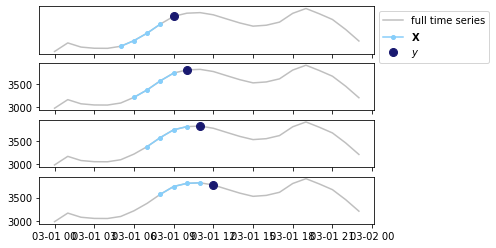

time: 2.89 s (started: 2021-12-21 08:05:27 +00:00)


In [ ]:
#finding the indices as integers for time substraction below:
start = np.where(new_dataframe.index == '2014-03-01 00:00:00')[0][0]
middle = np.where(new_dataframe.index == '2014-03-01 12:00:00')[0][0]
end = np.where(new_dataframe.index == '2014-03-02 00:00:00')[0][0]
#sliding window width:
window = 4
#Plotting a sliding interval sample:
fig, ax = plt.subplots(nrows=4,sharex=True);
for i in range(4): 
    full = new_dataframe.iloc[start:end]['load']
    train = new_dataframe.iloc[middle - i - window:middle - i ]['load']
    predict = new_dataframe.iloc[middle - i:middle - i + 1]['load']

    ax[3-i].plot((full + 2*i),c='grey', alpha=0.5);
    ax[3-i].plot((train + 2*i),c=colors['lightskyblue'], markersize=4,marker='o')
    ax[3-i].plot((predict + 2*i),c=colors['midnightblue'], markersize=8,marker='o', linestyle='')

ax[0].get_yaxis().set_ticks([]);
ax[0].legend(['full time series','$\mathbf{X}$','$y$'],bbox_to_anchor=(1, 1));


Let's follow the same logic and create our feature matrix A in this way.

In [ ]:
#finding the indices as integers for time substraction below:
start = np.where(new_dataframe.index == '2012-09-01 00:00:00')[0][0]
end = np.where(new_dataframe.index == '2014-11-04 00:00:00')[0][0]
#setting windows width:
window = 4
#empty datalist
dataX = []
dataY = []
column_names = []
for i in range(start,end-window):

    # Slice a window of features
    dataX.append((new_dataframe.iloc[i:i+window].to_numpy()).ravel())
    dataY.append(new_dataframe['load'].iloc[i+window] )

for j in range (1,window+1):
      column_names.append(['median_t_'+str(j),'std_t_'+str(j),'T_t_'+str(j),'load_t_'+str(j)])

column_names = itertools.chain(*column_names)
dataX = pd.DataFrame(np.vstack(dataX),index=new_dataframe.iloc[start+window:end].index)
dataX.columns = column_names
dataY =pd.Series(dataY,index=new_dataframe.iloc[start+window:end].index)
dataY.column = ['true_load']

time: 7.56 s (started: 2021-12-21 08:05:30 +00:00)


In [ ]:
#Original DF:
new_dataframe.loc['2012-09-01 00:00:00':'2014-09-04 00:00:00'].head(6)

,median,std,T,load
2012-09-01 00:00:00,3543.0,524.914199,59.33,2719.0
2012-09-01 01:00:00,3104.5,465.842964,69.67,2817.0
2012-09-01 02:00:00,2768.0,335.357521,67.33,2664.0
2012-09-01 03:00:00,2691.5,99.408249,69.33,2580.0
2012-09-01 04:00:00,2622.0,123.494939,67.67,2537.0
2012-09-01 05:00:00,2558.5,62.931179,65.00,2525.0


time: 41 ms (started: 2021-12-21 08:05:37 +00:00)


In [ ]:
dataX.head(2)

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,T_t_3,load_t_3,median_t_4,std_t_4,T_t_4,load_t_4
2012-09-01 04:00:00,3543.0,524.914199,59.33,2719.0,3104.5,465.842964,69.67,2817.0,2768.0,335.357521,67.33,2664.0,2691.5,99.408249,69.33,2580.0
2012-09-01 05:00:00,3104.5,465.842964,69.67,2817.0,2768.0,335.357521,67.33,2664.0,2691.5,99.408249,69.33,2580.0,2622.0,123.494939,67.67,2537.0


time: 81.3 ms (started: 2021-12-21 08:05:37 +00:00)


In [ ]:
dataY.head(2)

2012-09-01 04:00:00    2537.0
2012-09-01 05:00:00    2525.0
dtype: float64

time: 10.3 ms (started: 2021-12-21 08:05:37 +00:00)


In [ ]:
#Rescaling the data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
#Looking into the statistics again:
dataX.describe()

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,T_t_3,load_t_3,median_t_4,std_t_4,T_t_4,load_t_4
count,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04
mean,4.244628e-17,-3.871008e-16,-4.614909e-15,-4.174292e-16,4.200748e-16,-9.285560e-17,-9.070007e-16,5.720108e-17,-5.432238e-16,-3.632743e-16,-4.507507e-15,-2.645550e-16,5.858798e-17,-3.638643e-16,-4.058374e-15,2.257552e-16
std,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00
min,-2.356536e+00,-1.250854e+00,-3.150932e+00,-2.363943e+00,-2.356523e+00,-1.250961e+00,-3.150906e+00,-2.364070e+00,-2.356548e+00,-1.251018e+00,-3.150913e+00,-2.364173e+00,-2.356666e+00,-1.251030e+00,-3.150905e+00,-2.364310e+00
25%,-7.726966e-01,-8.791492e-01,-7.639865e-01,-7.721103e-01,-7.727081e-01,-8.791741e-01,-7.639432e-01,-7.722154e-01,-7.727602e-01,-8.791741e-01,-7.638814e-01,-7.722968e-01,-7.721740e-01,-8.791720e-01,-7.638207e-01,-7.723794e-01
50%,1.141806e-01,-3.143736e-01,9.416024e-02,1.191733e-01,1.141554e-01,-3.142749e-01,9.420957e-02,1.190803e-01,1.140882e-01,-3.141876e-01,9.429610e-02,1.190114e-01,1.140057e-01,-3.141646e-01,9.437566e-02,1.189593e-01
75%,6.730222e-01,7.707527e-01,7.982938e-01,6.788994e-01,6.729884e-01,7.708772e-01,7.983482e-01,6.788141e-01,6.729117e-01,7.710807e-01,7.984550e-01,6.787530e-01,6.728372e-01,7.711371e-01,7.985500e-01,6.787200e-01
max,3.458144e+00,4.153972e+00,2.446595e+00,3.420488e+00,3.458067e+00,4.155047e+00,2.446661e+00,3.420440e+00,3.457943e+00,4.155826e+00,2.446815e+00,3.420417e+00,3.457908e+00,4.156014e+00,2.446946e+00,3.420478e+00


time: 215 ms (started: 2021-12-21 08:05:37 +00:00)


In [ ]:
# Train-Validation-Test Split:
# We will split the data as training and test. No need for validation here. 
train_start_dt = '2012-09-01'
validation_start_dt = '2014-10-29'
test_start_dt = '2014-11-01'
test_end_dt = '2014-11-04'

#Let's use the same notation: 
X_train = dataX.copy()[(dataX.index >= train_start_dt)& (dataX.index < validation_start_dt)]
y_train = dataY.copy()[(dataY.index >= train_start_dt)& (dataY.index < validation_start_dt)]

X_val = dataX.copy()[(dataX.index >= validation_start_dt)& (dataX.index < test_start_dt)]
y_val = dataY.copy()[(dataY.index >= validation_start_dt)& (dataY.index < test_start_dt)]

X_test =  dataX.copy()[(dataX.index >= test_start_dt) & (dataX.index < test_end_dt)]
y_test =  dataY.copy()[(dataY.index >= test_start_dt) & (dataY.index < test_end_dt)]

print('Train data shape: ', X_train.shape, y_train.shape)
print('Validation data shape: ', X_val.shape, y_val.shape)
print('Test data shape: ', X_test.shape, y_test.shape)

Train data shape:  (18908, 16) (18908,)
Validation data shape:  (72, 16) (72,)
Test data shape:  (72, 16) (72,)
time: 34 ms (started: 2021-12-21 08:05:38 +00:00)


# MLP for Regression Problem
We can start creating a Feed Forward MLP as a base ANN architecture. We will follow the same work flow as in Active Session V. 

This simple structure is a good way to test the temporal complexity of the data. For a given objective, you may not need to further increase the complexity of the network. It can also be good baseline, before you shift to RNN, CNN etc.

## NN Architecture

We will first define a function to create the computational graph of the network; then prepare the callback objects. Note that we are using leaky ReLU with He initialization and l2 regularization; then add batchnorm layers after each dense layer. 

In [ ]:
def build_model_batch():
  #Here we will use Sequential API
  model = models.Sequential([
  layers.Dense(32, kernel_initializer="he_normal", input_shape=(X_train.shape[1],)),keras.layers.LeakyReLU(alpha=0.1),                           
  layers.BatchNormalization(),
  layers.Dense(32, kernel_regularizer=regularizers.l2(0.0001), kernel_initializer="he_normal"),keras.layers.LeakyReLU(alpha=0.1),
  layers.BatchNormalization(),
  layers.Dense(32, kernel_regularizer=regularizers.l2(0.0001), kernel_initializer="he_normal"),keras.layers.LeakyReLU(alpha=0.1),                           
  layers.BatchNormalization(),
  layers.Dense(32, kernel_regularizer=regularizers.l2(0.0001), kernel_initializer="he_normal"),keras.layers.LeakyReLU(alpha=0.1),                           
  layers.BatchNormalization(),
  layers.Dense(32, kernel_regularizer=regularizers.l2(0.0001), kernel_initializer="he_normal"),keras.layers.LeakyReLU(alpha=0.1),
  layers.BatchNormalization(),
  layers.Dense(1)
  ])
  
  model.compile(optimizer='Adam', loss=['mse'], metrics=['mae'])
  return model


time: 38 ms (started: 2021-12-21 08:05:38 +00:00)


In [ ]:
#Looking at the graph:
build_model_batch().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                544       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32)                0         
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

In [ ]:
#We will first create the object to feed fit() method:
myCheckpoint= keras.callbacks.ModelCheckpoint("my_best_model.h5", save_best_only=True)

time: 1.6 ms (started: 2021-12-21 08:05:42 +00:00)


In [ ]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
myEarly_stopping = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

time: 4.84 ms (started: 2021-12-21 08:05:42 +00:00)


## Training the Model

I would advise to look FAQ section of Keras (TF) if you encounter an issue during the training.

https://keras.io/getting_started/faq/

such as "Why is my training loss much higher than my testing loss?". 

In [ ]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 1000
batch_size = 10

time: 1.93 ms (started: 2021-12-21 08:05:42 +00:00)


In [ ]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
model_base = build_model_batch()

#Training step: Trains the model in silent mode (verbose = 0)
history_base = model_base.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val, y_val) , 
                                callbacks=[myCheckpoint,myEarly_stopping])#, verbose=0)
#Calling back the best model:
model_best = keras.models.load_model("my_best_model.h5")


Epoch 1/1000
1891/1891 [==============================] - 20s 9ms/step - loss: 10575401.0000 - mae: 3218.7817 - val_loss: 8913286.0000 - val_mae: 2979.7400
Epoch 2/1000
1891/1891 [==============================] - 16s 9ms/step - loss: 7838635.5000 - mae: 2784.7209 - val_loss: 6105337.5000 - val_mae: 2469.9236
Epoch 3/1000
1891/1891 [==============================] - 16s 9ms/step - loss: 4477736.0000 - mae: 2094.6895 - val_loss: 2818011.2500 - val_mae: 1676.0599
Epoch 4/1000
1891/1891 [==============================] - 16s 8ms/step - loss: 1723748.6250 - mae: 1275.1285 - val_loss: 726024.8750 - val_mae: 848.1713
Epoch 5/1000
1891/1891 [==============================] - 16s 8ms/step - loss: 332545.2500 - mae: 510.9735 - val_loss: 46082.8281 - val_mae: 186.9950
Epoch 6/1000
1891/1891 [==============================] - 16s 9ms/step - loss: 49019.8164 - mae: 175.8889 - val_loss: 12817.6699 - val_mae: 96.1960
Epoch 7/1000
1891/1891 [==============================] - 16s 8ms/step - loss: 3875

In [ ]:
#Let's look into the history recorded:
hist = pd.DataFrame(history_base.history)
hist.sample(3)

,loss,mae,val_loss,val_mae
30,35769.773438,149.158920,7158.060547,69.831818
14,39638.378906,158.622910,4537.582031,56.339256
11,38083.984375,154.808685,10626.471680,83.978096


time: 23.9 ms (started: 2021-12-21 08:16:07 +00:00)


In [ ]:
#Adding epoch column:
hist['epoch'] = history_base.epoch
# As you can see, we have the losses as well as mae for both training and CV data:
hist.sample(3)

,loss,mae,val_loss,val_mae,epoch
33,39133.097656,157.539825,5611.275879,61.897015,33
23,36483.746094,152.087509,6279.196289,65.803314,23
13,38887.156250,156.659515,9036.326172,77.624062,13


time: 21.6 ms (started: 2021-12-21 08:16:07 +00:00)


In [ ]:
# Defining our function to see the evolution of error:
def plot_learning_curves(history):
  #We will omit the first 10 points for a better visualization:
  plt.plot(history['epoch'],history['loss'], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'],history['val_loss'], "b-.", linewidth=1.5, label="Validation")
  plt.legend()
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("Loss (MSE)")

time: 5.07 ms (started: 2021-12-21 08:16:07 +00:00)


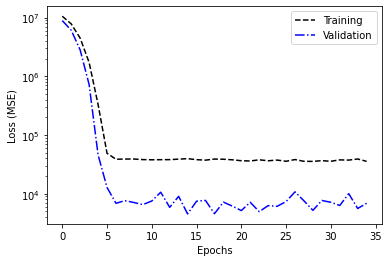

time: 570 ms (started: 2021-12-21 08:16:07 +00:00)


In [ ]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist)

The reason why we have less error in validation set might be:

+ Due to the regularization error applied during the training

+ Training loss is measured during each epoch (while it learns) yet the validation loss is calculated at the end of each epoch (after learning)

+ We might be lucky with the validation fraction of the data. It may be a simple portion of the data, compared to noisier training set.

+ How we split the training-test data. Here we use a large history of 2 years including many random events and anormalies. Three days into future might be a just a regular window. To test it, reduce the volume of the training data. You would see that the gap will be closed.

+ There is a mistake in the data preprocessing. Double check the data matrices!

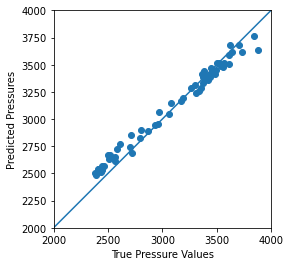

time: 503 ms (started: 2021-12-21 08:16:07 +00:00)


In [ ]:
# Calling trained model for predictions:
Y_test_predictions = pd.Series(model_best.predict(X_test).flatten(),index=X_test.index)
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test, Y_test_predictions)
plt.xlabel('True Load Values')
plt.ylabel('Predicted Load Values')
lims = [2000, 4000]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

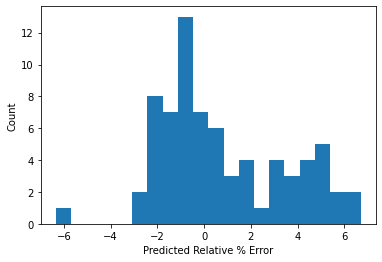

time: 269 ms (started: 2021-12-21 08:16:08 +00:00)


In [ ]:
# Calculating the error variations:
error_nn = (Y_test_predictions - y_test)/y_test*100
plt.hist(error_nn, bins=20)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [ ]:
#Calculating the mean absolutepercentage error:
abs_error_nn = abs(Y_test_predictions - y_test)/y_test*100
np.average(error_nn)

0.8058544298536613

time: 12.8 ms (started: 2021-12-21 08:16:08 +00:00)


In [ ]:
#Calculating R2 value:
r2_test = r2_score(y_test, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.97
time: 1.84 ms (started: 2021-12-21 08:16:08 +00:00)


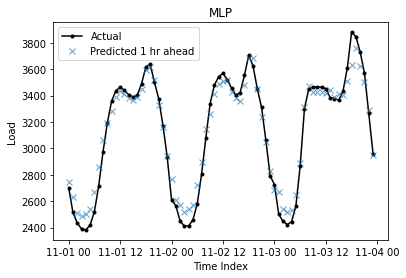

time: 252 ms (started: 2021-12-21 08:16:08 +00:00)


In [ ]:
#Plotting the Figure: 
plt.figure();
plt.plot(y_test, 'k.-');
plt.plot(Y_test_predictions, 'x', alpha=0.70);

plt.legend(['Actual',
            'Predicted 1 hr ahead'
            ]);
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('MLP');
mpl.rcParams['figure.figsize'] = [12.0, 6.0]

# RNN: Recurrent neural networks

RNN layer uses a for-loop to iterate over the timesteps of a sequence, while maintaining an internal state that encodes information about the timesteps it has seen so far (acts like a memory). There are two paths to follow in TF:

1. Use the built-in `keras.layers.RNN`, `keras.layers.LSTM`, `keras.layers.GRU` layers to quickly build recurrent models without having to make difficult configuration choices.

2.  Create your own RNN cell layer and use it with the generic `keras.layers.RNN` layer. In this way, you can test different ideas in a flexible way with minimal coding.

In this lecture, we will use the already available tools in TF. Let's start with the simplest architecture.

## Simple RNN

### Data Preprocessing

Let's make things more difficult for RNN and remove the past features from X.

In [ ]:
#Checking Data:
data.sample(3)

,load,T
2006-07-15 02:00:00,3184.0,72.00
2008-10-05 17:00:00,3269.0,57.33
2013-01-19 19:00:00,3872.0,38.00


time: 23.4 ms (started: 2021-12-21 08:16:09 +00:00)


In [ ]:
#Adding statistics features in dataframes:
#------------------------------------------------
#Let's use only the load data;
load_data = data[['load']]
#Defining the window width:
width = 4
#Calling Rolling:
window = load_data.rolling(window=width)
#Let's save as a new DF. We will add median and std to the load column:
new_dataframe = pd.concat([window.median(), window.std(),data['T'], data['load']], axis=1)
new_dataframe.columns = ['median', 'std','T', 'load']
new_dataframe = new_dataframe.dropna() 
new_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78885 entries, 2006-01-01 03:00:00 to 2014-12-31 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   median  78885 non-null  float64
 1   std     78885 non-null  float64
 2   T       78885 non-null  float64
 3   load    78885 non-null  float64
dtypes: float64(4)
memory usage: 3.0 MB
time: 56.9 ms (started: 2021-12-21 08:16:09 +00:00)


In [ ]:
new_dataframe.head(3)

,median,std,T,load
2006-01-01 03:00:00,2919.0,117.882710,21.33,2758.0
2006-01-01 04:00:00,2805.5,133.827003,19.00,2705.0
2006-01-01 05:00:00,2733.5,68.854315,19.33,2709.0


time: 17.3 ms (started: 2021-12-21 08:16:09 +00:00)


In [ ]:
#Here we will create a dataset we want to run the model on.
#We will train it for two years and test it. Let's select the 
#starting and end points in time.
#
#finding the indices as integers for time substraction below:
start = np.where(new_dataframe.index == '2012-09-01 00:00:00')[0][0]
end = np.where(new_dataframe.index == '2014-12-31 00:00:00')[0][0]
#setting windows width: this is how many points in time
#you would like to add. I take it as 4. I expect RNN to figure it out
#by itself. I am not feeding the past as a feature like MLP.
window = 1
#empty datalist
dataX = []
dataY = []
column_names = []
for i in range(start,end-window):

    # Slice a window of features
    dataX.append((new_dataframe.iloc[i:i+window].to_numpy()).ravel())
    dataY.append(new_dataframe['load'].iloc[i+window] )

for j in range (1,window+1):
      column_names.append(['median_t_'+str(j),'std_t_'+str(j),'T_t_'+str(j),'load_t_'+str(j)])

column_names = itertools.chain(*column_names)
dataX = pd.DataFrame(np.vstack(dataX),index=new_dataframe.iloc[start+window:end].index)
dataX.columns = column_names
dataY =pd.Series(dataY,index=new_dataframe.iloc[start+window:end].index)
dataY.column = ['true_load']

time: 4.14 s (started: 2021-12-21 08:16:09 +00:00)


In [ ]:
dataX

,median_t_1,std_t_1,T_t_1,load_t_1
2012-09-01 01:00:00,3543.0,524.914199,59.33,2719.0
2012-09-01 02:00:00,3104.5,465.842964,69.67,2817.0
2012-09-01 03:00:00,2768.0,335.357521,67.33,2664.0
2012-09-01 04:00:00,2691.5,99.408249,69.33,2580.0
2012-09-01 05:00:00,2622.0,123.494939,67.67,2537.0
...,...,...,...,...
2014-12-30 19:00:00,4059.0,247.965051,20.67,4413.0
2014-12-30 20:00:00,4277.5,217.882805,18.67,4374.0
2014-12-30 21:00:00,4322.0,104.793448,18.67,4270.0
2014-12-30 22:00:00,4322.0,122.123912,18.33,4140.0


time: 27.3 ms (started: 2021-12-21 08:16:13 +00:00)


In [ ]:
dataY.head(3)

2012-09-01 01:00:00    2817.0
2012-09-01 02:00:00    2664.0
2012-09-01 03:00:00    2580.0
dtype: float64

time: 12.1 ms (started: 2021-12-21 08:16:13 +00:00)


In [ ]:
#Rescaling the data 
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
sX.fit(dataX[featuresToScale])
dataX.loc[:,featuresToScale] = sX.transform(dataX[featuresToScale])
#Looking into the statistics again:
dataX

,median_t_1,std_t_1,T_t_1,load_t_1
2012-09-01 01:00:00,0.431904,2.906908,0.661013,-1.058795
2012-09-01 02:00:00,-0.370704,2.436443,1.200695,-0.882941
2012-09-01 03:00:00,-0.986617,1.397207,1.078562,-1.157489
2012-09-01 04:00:00,-1.126639,-0.481983,1.182949,-1.308221
2012-09-01 05:00:00,-1.253848,-0.290147,1.096308,-1.385382
...,...,...,...,...
2014-12-30 19:00:00,1.376365,0.701180,-1.356794,1.980971
2014-12-30 20:00:00,1.776296,0.461594,-1.461181,1.910988
2014-12-30 21:00:00,1.857747,-0.439093,-1.461181,1.724368
2014-12-30 22:00:00,1.857747,-0.301067,-1.478927,1.491092


time: 49.6 ms (started: 2021-12-21 08:16:13 +00:00)


In [ ]:
#Temperature for weather forecasting (later used in multistep forecasting):
temp_test = dataX['T_t_1']
temp_test

2012-09-01 01:00:00    0.661013
2012-09-01 02:00:00    1.200695
2012-09-01 03:00:00    1.078562
2012-09-01 04:00:00    1.182949
2012-09-01 05:00:00    1.096308
                         ...   
2014-12-30 19:00:00   -1.356794
2014-12-30 20:00:00   -1.461181
2014-12-30 21:00:00   -1.461181
2014-12-30 22:00:00   -1.478927
2014-12-30 23:00:00   -1.861507
Name: T_t_1, Length: 20423, dtype: float64

time: 9.29 ms (started: 2021-12-21 08:16:13 +00:00)


In [ ]:
# Train-Validation-Test Split:
# We will split the data as training and test. No need for validation here. 
train_start_dt = '2012-09-01'
validation_start_dt = '2014-10-29'
test_start_dt = '2014-11-04'
test_end_dt = '2014-11-10'

#Let's use the same notation: 
X_train0 = dataX.copy()[(dataX.index >= train_start_dt)& (dataX.index < validation_start_dt)]
y_train0 = dataY.copy()[(dataY.index >= train_start_dt)& (dataY.index < validation_start_dt)]

X_val0 = dataX.copy()[(dataX.index >= validation_start_dt)& (dataX.index < test_start_dt)]
y_val0 = dataY.copy()[(dataY.index >= validation_start_dt)& (dataY.index < test_start_dt)]

X_test0 =  dataX.copy()[(dataX.index >= test_start_dt) & (dataX.index < test_end_dt)]
y_test0 =  dataY.copy()[(dataY.index >= test_start_dt) & (dataY.index < test_end_dt)]

print('Train data shape: ', X_train0.shape, y_train0.shape)
print('Validation data shape: ', X_val0.shape, y_val0.shape)
print('Test data shape: ', X_test0.shape, y_test0.shape)

Train data shape:  (18911, 4) (18911,)
Validation data shape:  (144, 4) (144,)
Test data shape:  (144, 4) (144,)
time: 19.8 ms (started: 2021-12-21 08:16:13 +00:00)


### Reshaping the data for temporal analysis

So far, we organized the X matrix and the labels y in a way that we do not have explicit time information on the data; we were looking the dataset in a 'frozen state' and solve it as a regression problem. The temporal data was only involved as a sliding window hence for 4 features, we created 16 dimensions. Let's remember the shapes of the data and columns:

In [ ]:
print('Train data shape: ', X_train0.shape, y_train0.shape)
print('Validation data shape: ', X_val0.shape, y_val0.shape)
print('Test data shape: ', X_test0.shape, y_test0.shape)

Train data shape:  (18911, 4) (18911,)
Validation data shape:  (144, 4) (144,)
Test data shape:  (144, 4) (144,)
time: 5.73 ms (started: 2021-12-21 08:16:13 +00:00)


In RNN, however, the model expects you to provide the temporal data: the expected dimensions are  **[samples, timesteps, features]**. Currently, we only have **[samples, features]**. We need to reshape the data into the 3D format to be able to feed it into the model:

https://keras.io/api/layers/recurrent_layers/simple_rnn/


Side note: Here we are handling the data manually  but you can also use Keras preprocessing tools such as TimeseriesGenerator (https://keras.io/api/preprocessing/timeseries/).

In [ ]:
#Reshaping the 2D [samples, features] data into 3D:[samples, timesteps, features]
#Note that reshape is no longer available in Pandas; this is why we convert it to numpy
#array first.
def dimension_fix(train, label, n_input = 24, n_output=24,batch_size = 32):

  #Preparing the time stamps:
  label_index = label.index

  train = train.to_numpy()
  label = label.to_numpy()
  X, y = list(), list()

# looping one time step at a time:
  for i_start in range(len(train)):
  # define the end of the sequence
    i_end = i_start + n_input
  # ensure we have enough data
    if i_end <= len(train):
      X.append(train[i_start:i_end, :])

#------------------------------------------------------

  for i_start in range(len(label)):
  # define the end of the input sequence
    i_end = i_start + n_input - 1
    out_end = i_end + n_output
  # ensure we have enough data
    if out_end <= len(label):
      y.append(label[i_end:out_end])
  #------------------------#
  #--------Clean up--------#
  #------------------------#
  #we need to omit the data that does not have labels:
  if n_output > 1:
    ranged = [i for i in range(-1,-n_output,-1)]
    X = np.delete(X, ranged, axis=0)

  # finding the remain wrt batch size (assumed 32 here)
  reminder_elements = len(X)%batch_size
  #filtering the matrices: creating a range
  ranged_x = [-i for i in range(reminder_elements)]
  ranged_y = [-i for i in range(reminder_elements)]
  #Filtering X:
  X = np.delete(X, ranged_x, axis=0)
  #Filtering y: due to the n_input shift
  label_index = label_index[n_input:]
  #Filtering y: due to mod operation
  y = np.delete(y, ranged_y, axis=0)
  label_index = label_index[0:len(y)]

  return np.array(X), np.array(y), label_index


time: 41 ms (started: 2021-12-21 08:16:13 +00:00)


In [ ]:
#Reshaping the 2D data into 3D:[samples, timesteps, features]
#Note that reshape is no longer available in Pandas; this is why we convert it to numpy
#array first.
X_train, y_train, iy_train  = dimension_fix(X_train0, y_train0,24,1)
X_val, y_val, iy_val = dimension_fix(X_val0, y_val0,24,1)
X_test, y_test, iy_test = dimension_fix(X_test0, y_test0,24,1)
print(X_train.shape, y_train.shape,X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(18880, 24, 4) (18880, 1) (96, 24, 4) (96, 1) (96, 24, 4) (96, 1)
time: 74.1 ms (started: 2021-12-21 08:16:13 +00:00)


In [ ]:
#Check the shifts by 24 hours:
print(iy_test[0],y_test[0])
print(iy_test[1],y_test[1])
print(iy_test[2],y_test[2])

2014-11-05 00:00:00 [2640.]
2014-11-05 01:00:00 [2538.]
2014-11-05 02:00:00 [2459.]
time: 4.35 ms (started: 2021-12-21 08:16:13 +00:00)


In [ ]:
#Original dataset:
y_test0[24:len(y_test)+24].iloc[:3]

2014-11-05 00:00:00    2640.0
2014-11-05 01:00:00    2538.0
2014-11-05 02:00:00    2459.0
dtype: float64

time: 8.9 ms (started: 2021-12-21 08:16:13 +00:00)


### RNN Architecture

We will follow the same method to create our computational network. We will use `Sequential` model and add `SimpleRNN` instead of dense layers.

**Important note:**
You must set `return_sequences=True` for all recurrent layers. Otherwise, the next recurrent layer will complain that you are not feeding the sequences in the expected 3D format. You need to pass time information.

Look at the function below. You will notice that there are some further important differences compared to MLP. 


**SimpleRNN:**

```
tf.keras.layers.SimpleRNN(
    units,
    activation="tanh",
    use_bias=True,
    kernel_initializer="glorot_uniform",
    recurrent_initializer="orthogonal",
    bias_initializer="zeros",
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    unroll=False,
    **kwargs
)

```

Note:  `dropout` hyperparameter defines the dropout rate to apply to the inputs, while `recurrent_dropout` defines the dropout rate for the hidden states at each time step.


In [ ]:
def build_model_RNN():
  #Here we will use Sequential API
  n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
  model = models.Sequential([
  # At the input layer; we can fix the input shape as n_timesteps.
  # In this case, it expects fix sizes of time steps. If set to none, 
  #it can vary from instance to instance.
  #-------------------
  # Stateful network: you pass the states from the previous batch to the current one.
  # If you want a stateful network, you need to define the batch input shape instead of input shape.
  # In this case, however, the shapes must be the same for each batch and you can make
  #predictions with fixed sizes (same as batch size)
  #For instance:
  #If you prefer online training (batch=1), you can make predictions with size (1,none,n_features);
  #If you prefer mini-batch training (batch=32), you can make predictions with size (32,none,n_features);
  #-------------------
  #Note: if return_sequences is false; you will only pass the last hidden state output. 
  layers.SimpleRNN(32, return_sequences=True,input_shape=(None, n_features), stateful=False), 
  layers.BatchNormalization(),
  layers.SimpleRNN(32, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.SimpleRNN(32, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.SimpleRNN(32, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.SimpleRNN(32, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.SimpleRNN(32, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.SimpleRNN(32, stateful=False),
  layers.BatchNormalization(),
  layers.Dense(n_outputs)                     
  ])
  model.compile(optimizer='Adam',loss='mse',metrics='mae') 
  return model


time: 15.4 ms (started: 2021-12-21 08:16:13 +00:00)


Note that we added a Dense layer with one neuron as the last layer. SimpleRNN layer uses the tanh activation function by default, hence the predicted values must lie within the range –1 to 1. If you change the last RNN layer, we must remove `return_sequences=True` from the last recurrent layer to feed the dense layer 2D X matrix.

Here I included batchnorm to regularize the flow of information between layers. Nonetheless, it has been argued in the literature that it is not very useful to add these layers for time series analysis. It is argued to be due to the fact that the same batchnorm layer will be used at each time step, with the same parameters, regardless of the actual scale and offset of the inputs and hidden state (https://arxiv.org/abs/1510.01378). For our case, however, model fails without batchnorm. Lesson learnt: be aware of the possible source of problems yet do not 100% rely on generalizations.

A better way would be Layer Normalization (https://arxiv.org/abs/1607.06450) but this is needed to be implemented to Keras first. We will test it below.

In [ ]:
#Looking at the graph:
build_model_RNN().summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 32)          1184      
                                                                 
 batch_normalization_10 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 batch_normalization_11 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 batch_normalization_12 (Bat  (None, None, 32)        

In [ ]:
#We will first create the object to feed fit() method:
myCheckpointRNN= keras.callbacks.ModelCheckpoint("my_best_model_RNN.h5", save_best_only=True)

time: 1.41 ms (started: 2021-12-21 08:16:14 +00:00)


In [ ]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
myEarly_stoppingRNN = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

time: 1.95 ms (started: 2021-12-21 08:16:14 +00:00)


### Training the Model

In [ ]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 150
batch_size = 32

time: 2.32 ms (started: 2021-12-21 08:16:14 +00:00)


In [ ]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
model_rnn = build_model_RNN()

#Training step: Trains the model in silent mode (verbose = 0)
history_rnn = model_rnn.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val, y_val) , 
                                 callbacks=[myCheckpointRNN,myEarly_stoppingRNN])#, verbose=0)
#Calling back the best model:
model_best_RNN = keras.models.load_model("my_best_model_RNN.h5")


Epoch 1/150
590/590 [==============================] - 91s 144ms/step - loss: 11159137.0000 - mae: 3297.1816 - val_loss: 9867441.0000 - val_mae: 3116.5977
Epoch 2/150
590/590 [==============================] - 84s 142ms/step - loss: 10739016.0000 - mae: 3244.4092 - val_loss: 9565247.0000 - val_mae: 3078.3474
Epoch 3/150
590/590 [==============================] - 84s 143ms/step - loss: 10024444.0000 - mae: 3146.4768 - val_loss: 9038909.0000 - val_mae: 2999.8320
Epoch 4/150
590/590 [==============================] - 83s 141ms/step - loss: 9131503.0000 - mae: 3012.4216 - val_loss: 8374486.5000 - val_mae: 2891.3689
Epoch 5/150
590/590 [==============================] - 83s 140ms/step - loss: 8145908.5000 - mae: 2849.8191 - val_loss: 7598678.5000 - val_mae: 2755.9797
Epoch 6/150
590/590 [==============================] - 83s 141ms/step - loss: 7108862.5000 - mae: 2662.4487 - val_loss: 6402493.5000 - val_mae: 2529.6169
Epoch 7/150
590/590 [==============================] - 83s 141ms/step - l

In [ ]:
#Let's look into the history recorded:
histRNN = pd.DataFrame(history_rnn.history)
histRNN.sample(3)

,loss,mae,val_loss,val_mae
57,1.250244e+04,89.078072,2.084913e+03,32.912899
25,1.214666e+04,87.424591,4.904242e+03,51.008636
5,7.108862e+06,2662.448730,6.402494e+06,2529.616943


time: 17.4 ms (started: 2021-12-21 09:59:43 +00:00)


In [ ]:
#Adding epoch column:
histRNN['epoch'] = history_rnn.epoch
# As you can see, we have the losses as well as mae for both training and CV data:
histRNN.sample(3)

,loss,mae,val_loss,val_mae,epoch
54,10979.554688,84.154556,3667.397217,46.802647,54
38,12008.145508,87.511314,2154.943115,32.952305,38
24,13467.330078,92.939331,2742.214111,35.581417,24


time: 24.8 ms (started: 2021-12-21 09:59:43 +00:00)


In [ ]:
# Defining our function to see the evolution of error:
def plot_learning_curves(history):
  #We will omit the first 10 points for a better visualization:
  plt.plot(history['epoch'],history['loss'], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'],history['val_loss'], "b-.", linewidth=1.5, label="Validation")
  plt.legend()
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("Loss (MSE)")

time: 3.61 ms (started: 2021-12-21 09:59:43 +00:00)


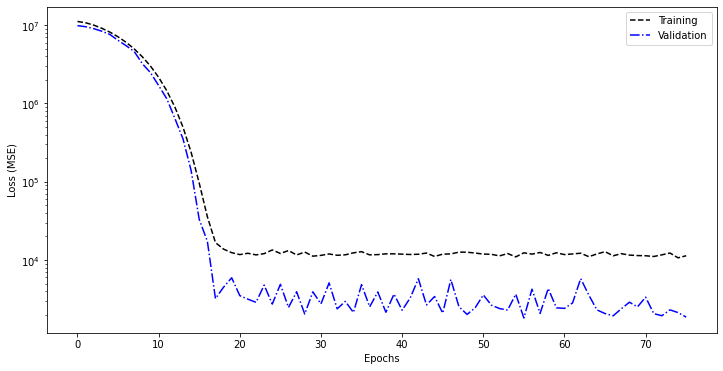

time: 555 ms (started: 2021-12-21 09:59:43 +00:00)


In [ ]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(histRNN)

In [ ]:
#Label and indices:
#Since we have shifted the data by 4 width windows, initial label DF is to be filtered.
y_test_filtered = y_test0.loc[iy_test]
y_test_filtered

2014-11-05 00:00:00    2640.0
2014-11-05 01:00:00    2538.0
2014-11-05 02:00:00    2459.0
2014-11-05 03:00:00    2423.0
2014-11-05 04:00:00    2429.0
                        ...  
2014-11-08 19:00:00    3640.0
2014-11-08 20:00:00    3504.0
2014-11-08 21:00:00    3378.0
2014-11-08 22:00:00    3215.0
2014-11-08 23:00:00    2924.0
Length: 96, dtype: float64

time: 8.93 ms (started: 2021-12-21 09:59:44 +00:00)


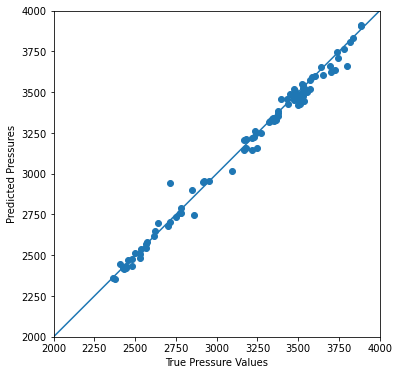

time: 1.16 s (started: 2021-12-21 09:59:44 +00:00)


In [ ]:
# Calling trained model for predictions:
Y_test_predictions = pd.Series(model_best_RNN.predict(X_test).flatten(),index=y_test_filtered.index)

#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test_filtered, Y_test_predictions)
plt.xlabel('True Load Values')
plt.ylabel('Predicted Loads')
lims = [2000, 4000]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

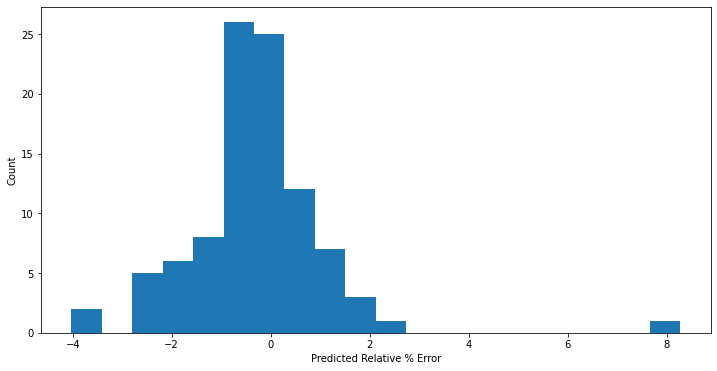

time: 276 ms (started: 2021-12-21 09:59:45 +00:00)


In [ ]:
# Calculating the error variations:
error_nn = (Y_test_predictions - y_test_filtered)/y_test_filtered*100
plt.hist(error_nn, bins=20)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [ ]:
#Calculating the mean absolutepercentage error:
abs_error_nn = abs(Y_test_predictions - y_test_filtered)/y_test_filtered*100
np.average(error_nn)

-0.32358959742836635

time: 8.39 ms (started: 2021-12-21 09:59:45 +00:00)


In [ ]:
#Calculating R2 value:
r2_test = r2_score(y_test_filtered, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.99
time: 4.57 ms (started: 2021-12-21 09:59:45 +00:00)


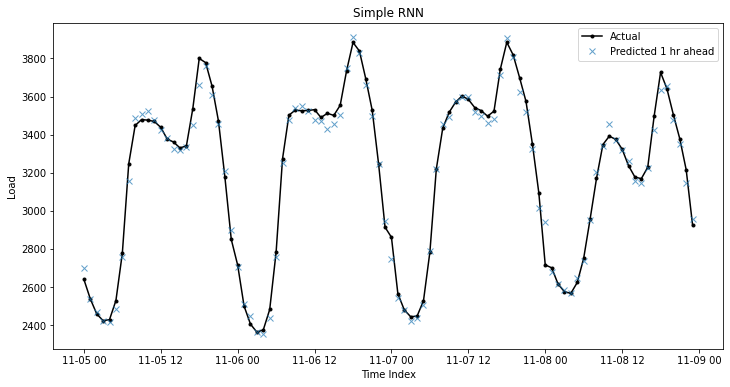

time: 268 ms (started: 2021-12-21 09:59:45 +00:00)


In [ ]:
#Plotting the Figure: 
plt.figure();
plt.plot(y_test_filtered, 'k.-');
plt.plot(Y_test_predictions, 'x', alpha=0.70);

plt.legend(['Actual',
            'Predicted 1 hr ahead'
            ]);
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('Simple RNN');
mpl.rcParams['figure.figsize'] = [12.0, 6.0]

Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful

## RNN for multi-step forecasting

Here we can follow two paths: we can create a model that predicts 24 steps in future directly; or we can feedback our prediction to X matrix and make consecutive predictions. For the former, you need to prepare labels as vectors with the size of interest (24) and train on that data. The last layer should also be modified to print 24 values (a dense layer with 24 nodes). For the former, we can use our model directly. In this case, however, the error would be higher as the error will accumulate over time (rather than learning to predict 24 hours ahead). 

In [ ]:
#Reshaping the 2D data into 3D:[samples, timesteps, features]
#Note that reshape is no longer available in Pandas; this is why we convert it to numpy
#array first.
X_train, y_train, iy_train  = dimension_fix(X_train0, y_train0,24,24)
X_val, y_val, iy_val = dimension_fix(X_val0, y_val0,24,24)
X_test, y_test, iy_test = dimension_fix(X_test0, y_test0,24,24)
print(X_train.shape, y_train.shape,X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(18848, 24, 4) (18848, 24) (96, 24, 4) (96, 24) (96, 24, 4) (96, 24)
time: 78 ms (started: 2021-12-21 09:59:45 +00:00)


In [ ]:
def build_model_RNN_2():
  #Here we will use Sequential API
  n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
  model = models.Sequential([
  # At the input layer; we can fix the input shape as n_timesteps.
  # In this case, it expects fix sizes of time steps. If set to none, it can vary.
  # Note that, however, the shapes must be the same for each batch. 
  # Another limitation is the "predict". Predictions must be made with same batch sizes.
  layers.SimpleRNN(32, return_sequences=True, 
                   batch_input_shape=(32, None, n_features), stateful=True), 
  layers.BatchNormalization(),
  layers.SimpleRNN(32, return_sequences=True, stateful=True),
  layers.BatchNormalization(),
  layers.SimpleRNN(32, return_sequences=True, stateful=True),
  layers.BatchNormalization(),
  layers.SimpleRNN(32, return_sequences=True, stateful=True),
  layers.BatchNormalization(),
  layers.SimpleRNN(32, stateful=True),
  layers.BatchNormalization(),
  layers.Dense(n_outputs)                     
  ])
  model.compile(optimizer='Adam',loss='mse',metrics='mae') 
  return model


time: 8.17 ms (started: 2021-12-21 09:59:46 +00:00)


If this model is trained, it takes about 10 minutes for one epoch; ~ 10 times slower to train. This is why I omit it in the lecture but you can try it yourself later on. Furthermore, encoder-decoder architecture is more useful for that purpose (we will see at the end of the lecture).

Here we will just try to use the trained model for future predictions, one hour at a time.

### Multistep: 1 hr at a time

In [ ]:
#Reshaping the 2D data into 3D:[samples, timesteps, features]
#Note that reshape is no longer available in Pandas; this is why we convert it to numpy
#array first.
X_train, y_train, iy_train  = dimension_fix(X_train0, y_train0,24,1)
X_val, y_val, iy_val = dimension_fix(X_val0, y_val0,24,1)
X_test, y_test, iy_test = dimension_fix(X_test0, y_test0,24,1)
print(X_train.shape, y_train.shape,X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(18880, 24, 4) (18880, 1) (96, 24, 4) (96, 1) (96, 24, 4) (96, 1)
time: 66.9 ms (started: 2021-12-21 09:59:46 +00:00)


In [ ]:
X_test[0]

array([[-0.35606169,  1.79197761,  0.22623962, -1.13057255],
       [-0.89235431,  1.16481917, -0.71324627, -1.29745466],
       [-1.2346298 ,  0.27439463, -0.80040968, -1.41947599],
       [-1.38197299, -0.62535648, -0.88705116, -1.45357018],
       [-1.44969595, -0.96324176, -0.85260334, -1.43024257],
       [-1.44969595, -0.81010618, -0.80040968, -1.22747184],
       [-1.35177221,  0.27342461, -0.69602236, -0.7034979 ],
       [-0.98112629,  1.74659534, -0.59163504,  0.09502402],
       [-0.30664223,  1.99613009, -0.57388919,  0.38213303],
       [ 0.24703871,  1.05756652, -0.3828604 ,  0.43417154],
       [ 0.40444883, -0.57567265, -0.20853357,  0.40366621],
       [ 0.43098891, -1.14906684, -0.01750477,  0.44314369],
       [ 0.43098891, -1.14906684,  0.19126987,  0.38213303],
       [ 0.40444883, -1.0013327 ,  0.31340304,  0.29779476],
       [ 0.3504535 , -0.9593418 ,  0.3655967 ,  0.29779476],
       [ 0.30744027, -1.00566578,  0.43501427,  0.23498966],
       [ 0.30560992, -1.

time: 8.55 ms (started: 2021-12-21 09:59:46 +00:00)


In [ ]:
#Defining the window width:
width = 4
rnn_window = X_train.shape[1]
#Last loads: will be used for median and std calculation:
last_loads = np.array([ X_test[0][i][3] for i in range(rnn_window-width, rnn_window)])
last_loads

array([ 0.69795294,  0.4090495 , -0.13466318, -0.70708676])

time: 14.5 ms (started: 2021-12-21 09:59:46 +00:00)


In [ ]:
#Creating series for predictions:
y_predicted =pd.Series(index=y_test_filtered.index)

time: 3.78 ms (started: 2021-12-21 09:59:46 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [ ]:
#Model is already trained so let's use it directly:
# Modifying the shape of initial test point for RNN
# [samples, timesteps, features] is needed. Currently, we only have [timesteps, features].
X_test_last = X_test[0].reshape((1,X_test[0].shape[0], X_test[0].shape[1]))
X_test_last

array([[[-0.35606169,  1.79197761,  0.22623962, -1.13057255],
        [-0.89235431,  1.16481917, -0.71324627, -1.29745466],
        [-1.2346298 ,  0.27439463, -0.80040968, -1.41947599],
        [-1.38197299, -0.62535648, -0.88705116, -1.45357018],
        [-1.44969595, -0.96324176, -0.85260334, -1.43024257],
        [-1.44969595, -0.81010618, -0.80040968, -1.22747184],
        [-1.35177221,  0.27342461, -0.69602236, -0.7034979 ],
        [-0.98112629,  1.74659534, -0.59163504,  0.09502402],
        [-0.30664223,  1.99613009, -0.57388919,  0.38213303],
        [ 0.24703871,  1.05756652, -0.3828604 ,  0.43417154],
        [ 0.40444883, -0.57567265, -0.20853357,  0.40366621],
        [ 0.43098891, -1.14906684, -0.01750477,  0.44314369],
        [ 0.43098891, -1.14906684,  0.19126987,  0.38213303],
        [ 0.40444883, -1.0013327 ,  0.31340304,  0.29779476],
        [ 0.3504535 , -0.9593418 ,  0.3655967 ,  0.29779476],
        [ 0.30744027, -1.00566578,  0.43501427,  0.23498966],
        

time: 9.11 ms (started: 2021-12-21 09:59:46 +00:00)


In [ ]:
#Going into loop: we will loop over the y_test indices and update X_test_last at each loop:
case_indices = y_test_filtered.index
#For scaling the predictions:
dummy_array = np.zeros((1,4))
for case_index in case_indices:
  #Predicting with fitted RNN and writing the result on y_predicted at the same time:
  load_prediction = model_best_RNN.predict(X_test_last).flatten()[0]
  y_predicted.update(pd.Series(load_prediction,index=[case_index]))
  #Preparing the next X_test_last:
  #
  # We need to scale the load first:
  dummy_array[0,3] = load_prediction
  load_scaled = sX.transform(dummy_array)[0,3]
  #
  #---updating load list---:
  last_loads = np.delete(last_loads,0)
  last_loads = np.append(last_loads,load_scaled)
# print(last_loads)
  #
  #---finding new values:
  median_i = np.median(last_loads)
  std_i = np.std(last_loads)
  #here I assume that T data is available from weatherforecasting etc.
  time_index = pd.Timestamp(case_index) + DateOffset(hours=1)
  temp_i= temp_test.loc[time_index] #already scaled!
  #
  #shifting lines:
  for i in range (X_test_last.shape[1]-1):
    X_test_last[0][i]= X_test_last[0][i+1]
  X_test_last[0][X_test_last.shape[1]-1]=np.array([median_i,std_i,temp_i,load_scaled])


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid 

time: 8.17 s (started: 2021-12-21 09:59:46 +00:00)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


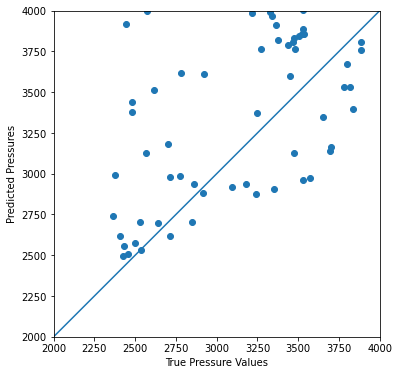

time: 244 ms (started: 2021-12-21 09:59:54 +00:00)


In [ ]:
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test_filtered, y_predicted)
plt.xlabel('True Load Values')
plt.ylabel('Predicted Loads')
lims = [2000, 4000]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

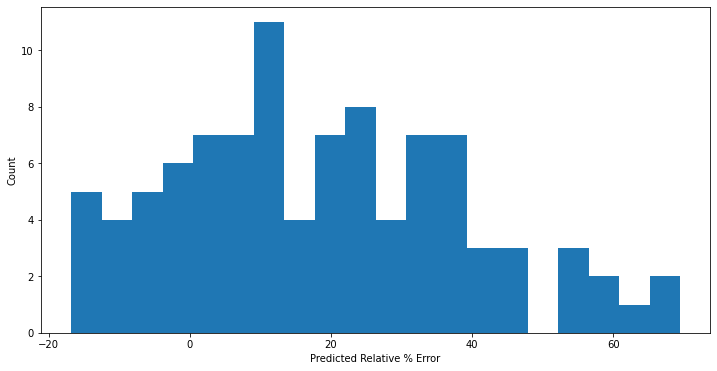

time: 255 ms (started: 2021-12-21 09:59:54 +00:00)


In [ ]:
# Calculating the error variations:
error_nn = (y_predicted - y_test_filtered)/y_test_filtered*100
plt.hist(error_nn, bins=20)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [ ]:
#Calculating the mean absolutepercentage error:
abs_error_nn = abs(y_predicted - y_test_filtered)/y_test_filtered*100
np.average(error_nn)

18.506028622313632

time: 7.78 ms (started: 2021-12-21 09:59:54 +00:00)


In [ ]:
#Calculating R2 value:
r2_test = r2_score(y_test_filtered, y_predicted)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  -2.44
time: 3.99 ms (started: 2021-12-21 09:59:54 +00:00)


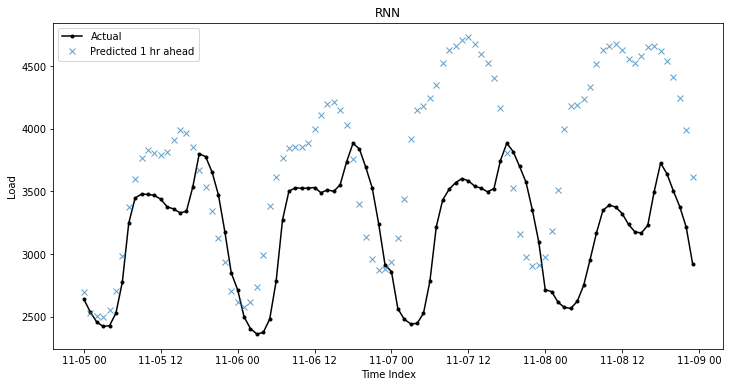

time: 256 ms (started: 2021-12-21 09:59:55 +00:00)


In [ ]:
#Plotting the Figure: 
plt.figure();
plt.plot(y_test_filtered, 'k.-');
plt.plot(y_predicted, 'x', alpha=0.70);

plt.legend(['Actual',
            'Predicted 1 hr ahead'
            ]);
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('RNN');
mpl.rcParams['figure.figsize'] = [12.0, 6.0]

# LSTM: How to alleviate the Short-Term Memory Problem

The Long Short-Term Memory (LSTM) cell was proposed in 1997 to solve the memory problem in RNN. Its implementation in TF is super-simple: simply write `LSTM` instead of the `SimpleRNN`. 



```
tf.keras.layers.LSTM(
    units,
    activation="tanh",
    recurrent_activation="sigmoid",
    use_bias=True,
    kernel_initializer="glorot_uniform",
    recurrent_initializer="orthogonal",
    bias_initializer="zeros",
    unit_forget_bias=True,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    time_major=False,
    unroll=False,
    **kwargs
)

```



In [ ]:
#Reshaping the 2D data into 3D:[samples, timesteps, features]
#Note that reshape is no longer available in Pandas; this is why we convert it to numpy
#array first.
X_train, y_train, iy_train  = dimension_fix(X_train0, y_train0,24,1)
X_val, y_val, iy_val = dimension_fix(X_val0, y_val0,24,1)
X_test, y_test, iy_test = dimension_fix(X_test0, y_test0,24,1)
print(X_train.shape, y_train.shape,X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(18880, 24, 4) (18880, 1) (96, 24, 4) (96, 1) (96, 24, 4) (96, 1)
time: 75.6 ms (started: 2021-12-21 09:59:55 +00:00)


In [ ]:
X_test[0]

array([[-0.35606169,  1.79197761,  0.22623962, -1.13057255],
       [-0.89235431,  1.16481917, -0.71324627, -1.29745466],
       [-1.2346298 ,  0.27439463, -0.80040968, -1.41947599],
       [-1.38197299, -0.62535648, -0.88705116, -1.45357018],
       [-1.44969595, -0.96324176, -0.85260334, -1.43024257],
       [-1.44969595, -0.81010618, -0.80040968, -1.22747184],
       [-1.35177221,  0.27342461, -0.69602236, -0.7034979 ],
       [-0.98112629,  1.74659534, -0.59163504,  0.09502402],
       [-0.30664223,  1.99613009, -0.57388919,  0.38213303],
       [ 0.24703871,  1.05756652, -0.3828604 ,  0.43417154],
       [ 0.40444883, -0.57567265, -0.20853357,  0.40366621],
       [ 0.43098891, -1.14906684, -0.01750477,  0.44314369],
       [ 0.43098891, -1.14906684,  0.19126987,  0.38213303],
       [ 0.40444883, -1.0013327 ,  0.31340304,  0.29779476],
       [ 0.3504535 , -0.9593418 ,  0.3655967 ,  0.29779476],
       [ 0.30744027, -1.00566578,  0.43501427,  0.23498966],
       [ 0.30560992, -1.

time: 5.95 ms (started: 2021-12-21 09:59:55 +00:00)


In [ ]:
#Defining the window width:
width = 4
rnn_window = X_train.shape[1]
#Last loads: will be used for median and std calculation:
last_loads = np.array([ X_test[0][i][3] for i in range(rnn_window-width, rnn_window)])
last_loads

array([ 0.69795294,  0.4090495 , -0.13466318, -0.70708676])

time: 5.68 ms (started: 2021-12-21 09:59:55 +00:00)


In [ ]:
#Creating series for predictions:
y_predicted =pd.Series(index=y_test_filtered.index)

time: 5.02 ms (started: 2021-12-21 09:59:55 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [ ]:
#Model is already trained so let's use it directly:
# Modifying the shape of initial test point for RNN
# [samples, timesteps, features] is needed. Currently, we only have [timesteps, features].
X_test_last = X_test[0].reshape((1,X_test[0].shape[0], X_test[0].shape[1]))
X_test_last

array([[[-0.35606169,  1.79197761,  0.22623962, -1.13057255],
        [-0.89235431,  1.16481917, -0.71324627, -1.29745466],
        [-1.2346298 ,  0.27439463, -0.80040968, -1.41947599],
        [-1.38197299, -0.62535648, -0.88705116, -1.45357018],
        [-1.44969595, -0.96324176, -0.85260334, -1.43024257],
        [-1.44969595, -0.81010618, -0.80040968, -1.22747184],
        [-1.35177221,  0.27342461, -0.69602236, -0.7034979 ],
        [-0.98112629,  1.74659534, -0.59163504,  0.09502402],
        [-0.30664223,  1.99613009, -0.57388919,  0.38213303],
        [ 0.24703871,  1.05756652, -0.3828604 ,  0.43417154],
        [ 0.40444883, -0.57567265, -0.20853357,  0.40366621],
        [ 0.43098891, -1.14906684, -0.01750477,  0.44314369],
        [ 0.43098891, -1.14906684,  0.19126987,  0.38213303],
        [ 0.40444883, -1.0013327 ,  0.31340304,  0.29779476],
        [ 0.3504535 , -0.9593418 ,  0.3655967 ,  0.29779476],
        [ 0.30744027, -1.00566578,  0.43501427,  0.23498966],
        

time: 10.1 ms (started: 2021-12-21 09:59:55 +00:00)


In [ ]:
#Data was already prepared:
print(X_train.shape, y_train.shape,X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(18880, 24, 4) (18880, 1) (96, 24, 4) (96, 1) (96, 24, 4) (96, 1)
time: 2.72 ms (started: 2021-12-21 09:59:55 +00:00)


In [ ]:
def build_model_LSTM():
  #Here we will use Sequential API
  n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
  model = models.Sequential([
                             
  layers.LSTM(32, return_sequences=True,input_shape=(None, n_features), stateful=False), 
  layers.BatchNormalization(),
  layers.LSTM(32, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.LSTM(32, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.LSTM(32, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.LSTM(32, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.LSTM(32, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.LSTM(32, stateful=False),
  layers.BatchNormalization(),
  layers.Dense(n_outputs)    

  ])
  model.compile(optimizer='Adam',loss='mse',metrics='mae') 
  return model


time: 25.4 ms (started: 2021-12-21 09:59:55 +00:00)


In [ ]:
#Looking at the graph:
build_model_LSTM().summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 32)          4736      
                                                                 
 batch_normalization_24 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 lstm_1 (LSTM)               (None, None, 32)          8320      
                                                                 
 batch_normalization_25 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 lstm_2 (LSTM)               (None, None, 32)          8320      
                                                                 
 batch_normalization_26 (Bat  (None, None, 32)        

In [ ]:
#We will first create the object to feed fit() method:
myCheckpointLSTM= keras.callbacks.ModelCheckpoint("my_best_model_LSTM.h5", save_best_only=True)

time: 1.13 ms (started: 2021-12-21 09:59:57 +00:00)


In [ ]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
myEarly_stoppingLSTM = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

time: 1.08 ms (started: 2021-12-21 09:59:57 +00:00)


### Model Training

In [ ]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 150
batch_size = 32

time: 1.06 ms (started: 2021-12-21 09:59:57 +00:00)


In [ ]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
model_LSTM = build_model_LSTM()

#Training step: Trains the model in silent mode (verbose = 0)
history_LSTM = model_LSTM.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val, y_val) , 
                                 callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM])#, verbose=0)
#Calling back the best model:
model_best_LSTM = keras.models.load_model("my_best_model_LSTM.h5")


Epoch 1/150
590/590 [==============================] - 54s 71ms/step - loss: 11156817.0000 - mae: 3296.9731 - val_loss: 9868971.0000 - val_mae: 3117.3157
Epoch 2/150
590/590 [==============================] - 39s 66ms/step - loss: 10738468.0000 - mae: 3244.4089 - val_loss: 9545129.0000 - val_mae: 3073.1628
Epoch 3/150
590/590 [==============================] - 38s 65ms/step - loss: 10025075.0000 - mae: 3146.6045 - val_loss: 8943432.0000 - val_mae: 2983.0901
Epoch 4/150
590/590 [==============================] - 39s 66ms/step - loss: 9132462.0000 - mae: 3012.7400 - val_loss: 8437049.0000 - val_mae: 2903.2214
Epoch 5/150
590/590 [==============================] - 39s 65ms/step - loss: 8146201.0000 - mae: 2849.9348 - val_loss: 7622407.5000 - val_mae: 2760.1052
Epoch 6/150
590/590 [==============================] - 39s 65ms/step - loss: 7109281.0000 - mae: 2662.7593 - val_loss: 6724036.0000 - val_mae: 2592.6892
Epoch 7/150
590/590 [==============================] - 39s 66ms/step - loss: 60

In [ ]:
#Let's look into the history recorded:
histLSTM = pd.DataFrame(history_LSTM.history)
histLSTM.sample(3)

,loss,mae,val_loss,val_mae
56,10273.355469,80.540657,2165.472656,31.835417
34,11535.634766,85.420685,2321.500000,33.867878
18,11336.574219,83.573242,2313.888916,37.000927


time: 19.9 ms (started: 2021-12-21 10:50:35 +00:00)


In [ ]:
#Adding epoch column:
histLSTM['epoch'] = history_LSTM.epoch
# As you can see, we have the losses as well as mae for both training and CV data:
histRNN.sample(3)

,loss,mae,val_loss,val_mae,epoch
54,1.097955e+04,84.154556,3.667397e+03,46.802647,54
9,2.995928e+06,1725.418579,2.470634e+06,1570.308594,9
45,1.190062e+04,86.922775,2.097691e+03,32.253002,45


time: 21.1 ms (started: 2021-12-21 10:50:35 +00:00)


In [ ]:
# Defining our function to see the evolution of error:
def plot_learning_curves(history):
  #We will omit the first 10 points for a better visualization:
  plt.plot(history['epoch'],history['loss'], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'],history['val_loss'], "b-.", linewidth=1.5, label="Validation")
  plt.legend()
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("Loss (MSE)")

time: 4.08 ms (started: 2021-12-21 10:50:35 +00:00)


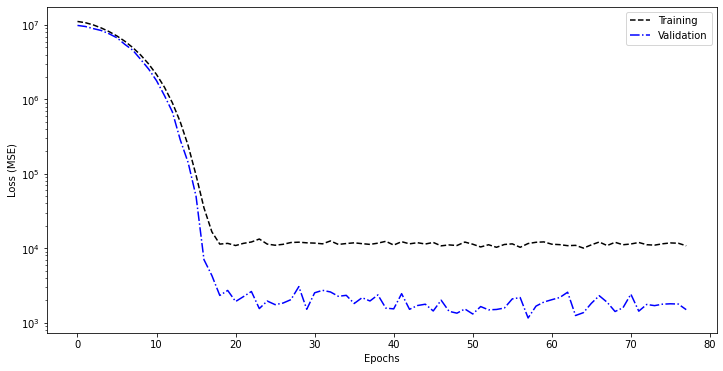

time: 589 ms (started: 2021-12-21 10:50:35 +00:00)


In [ ]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(histLSTM)

In [ ]:
#Label and indices:
#Since we have shifted the data by 4 width windows, initial label DF is to be filtered.
y_test_filtered = y_test0.loc[iy_test]
y_test_filtered

2014-11-05 00:00:00    2640.0
2014-11-05 01:00:00    2538.0
2014-11-05 02:00:00    2459.0
2014-11-05 03:00:00    2423.0
2014-11-05 04:00:00    2429.0
                        ...  
2014-11-08 19:00:00    3640.0
2014-11-08 20:00:00    3504.0
2014-11-08 21:00:00    3378.0
2014-11-08 22:00:00    3215.0
2014-11-08 23:00:00    2924.0
Length: 96, dtype: float64

time: 18.7 ms (started: 2021-12-21 10:50:35 +00:00)


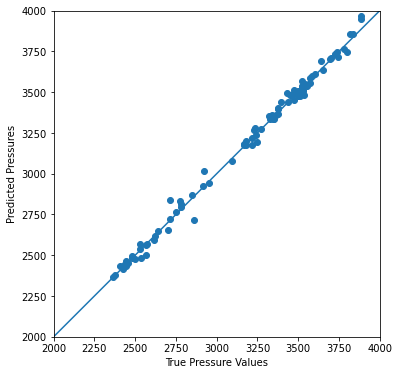

time: 3.68 s (started: 2021-12-21 10:50:35 +00:00)


In [ ]:
# Calling trained model for predictions:
Y_test_predictions = pd.Series(model_best_LSTM.predict(X_test).flatten(),index=y_test_filtered.index)

#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test_filtered, Y_test_predictions)
plt.xlabel('True Load Values')
plt.ylabel('Predicted Loads')
lims = [2000, 4000]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

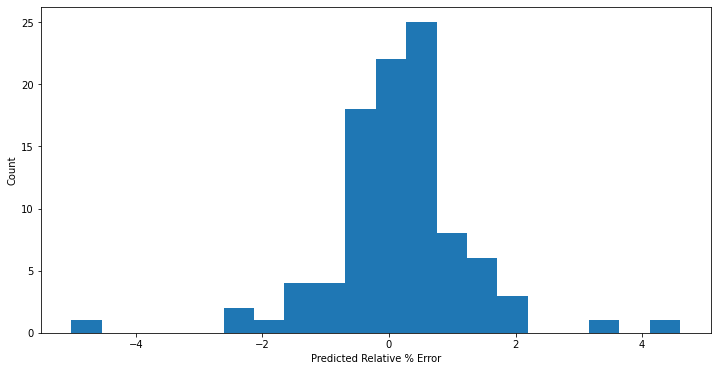

time: 249 ms (started: 2021-12-21 10:50:39 +00:00)


In [ ]:
# Calculating the error variations:
error_nn = (Y_test_predictions - y_test_filtered)/y_test_filtered*100
plt.hist(error_nn, bins=20)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [ ]:
#Calculating the mean absolutepercentage error:
abs_error_nn = abs(Y_test_predictions - y_test_filtered)/y_test_filtered*100
np.average(error_nn)

0.15647793253928663

time: 6.97 ms (started: 2021-12-21 10:50:39 +00:00)


In [ ]:
#Calculating R2 value:
r2_test = r2_score(y_test_filtered, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.99
time: 4.08 ms (started: 2021-12-21 10:50:39 +00:00)


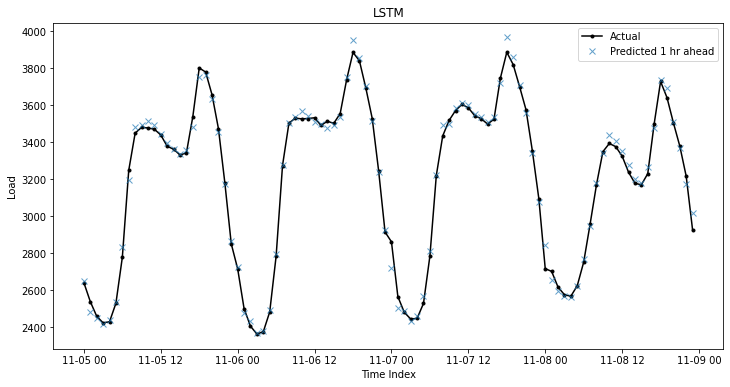

time: 291 ms (started: 2021-12-21 10:50:39 +00:00)


In [ ]:
#Plotting the Figure: 
plt.figure();
plt.plot(y_test_filtered, 'k.-');
plt.plot(Y_test_predictions, 'x', alpha=0.70);

plt.legend(['Actual',
            'Predicted 1 hr ahead'
            ]);
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('LSTM');
mpl.rcParams['figure.figsize'] = [12.0, 6.0]

## LSTM: multi-step forecasting

In [ ]:
#Reshaping the 2D data into 3D:[samples, timesteps, features]
#Note that reshape is no longer available in Pandas; this is why we convert it to numpy
#array first.
X_train, y_train, iy_train  = dimension_fix(X_train0, y_train0,24,1)
X_val, y_val, iy_val = dimension_fix(X_val0, y_val0,24,1)
X_test, y_test, iy_test = dimension_fix(X_test0, y_test0,24,1)
print(X_train.shape, y_train.shape,X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(18880, 24, 4) (18880, 1) (96, 24, 4) (96, 1) (96, 24, 4) (96, 1)
time: 70 ms (started: 2021-12-21 10:50:40 +00:00)


In [ ]:
#Defining the window width:
width = 4
rnn_window = X_train.shape[1]
#Last loads: will be used for median and std calculation:
last_loads = np.array([ X_test[0][i][3] for i in range(rnn_window-width, rnn_window)])
last_loads

array([ 0.69795294,  0.4090495 , -0.13466318, -0.70708676])

time: 10.4 ms (started: 2021-12-21 10:50:40 +00:00)


In [ ]:
#Creating series for predictions:
y_predicted =pd.Series(index=y_test_filtered.index)

time: 1.62 ms (started: 2021-12-21 10:50:40 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [ ]:
#Model is already trained so let's use it directly:
# Modifying the shape of initial test point for RNN
# [samples, timesteps, features] is needed. Currently, we only have [timesteps, features].
X_test_last = X_test[0].reshape((1,X_test[0].shape[0], X_test[0].shape[1]))
X_test_last

array([[[-0.35606169,  1.79197761,  0.22623962, -1.13057255],
        [-0.89235431,  1.16481917, -0.71324627, -1.29745466],
        [-1.2346298 ,  0.27439463, -0.80040968, -1.41947599],
        [-1.38197299, -0.62535648, -0.88705116, -1.45357018],
        [-1.44969595, -0.96324176, -0.85260334, -1.43024257],
        [-1.44969595, -0.81010618, -0.80040968, -1.22747184],
        [-1.35177221,  0.27342461, -0.69602236, -0.7034979 ],
        [-0.98112629,  1.74659534, -0.59163504,  0.09502402],
        [-0.30664223,  1.99613009, -0.57388919,  0.38213303],
        [ 0.24703871,  1.05756652, -0.3828604 ,  0.43417154],
        [ 0.40444883, -0.57567265, -0.20853357,  0.40366621],
        [ 0.43098891, -1.14906684, -0.01750477,  0.44314369],
        [ 0.43098891, -1.14906684,  0.19126987,  0.38213303],
        [ 0.40444883, -1.0013327 ,  0.31340304,  0.29779476],
        [ 0.3504535 , -0.9593418 ,  0.3655967 ,  0.29779476],
        [ 0.30744027, -1.00566578,  0.43501427,  0.23498966],
        

time: 13.1 ms (started: 2021-12-21 10:50:40 +00:00)


In [ ]:
#Going into loop: we will loop over the y_test indices and update X_test_last at each loop:
case_indices = y_test_filtered.index
#For scaling the predictions:
dummy_array = np.zeros((1,4))
for case_index in case_indices:
  #Predicting with fitted LSTM and writing the result on y_predicted at the same time:
  load_prediction = model_best_LSTM.predict(X_test_last).flatten()[0]
  y_predicted.update(pd.Series(load_prediction,index=[case_index]))
  #Preparing the next X_test_last:
  #
  # We need to scale the load first:
  dummy_array[0,3] = load_prediction
  load_scaled = sX.transform(dummy_array)[0,3]
  #
  #---updating load list---:
  last_loads = np.delete(last_loads,0)
  last_loads = np.append(last_loads,load_scaled)
# print(last_loads)
  #
  #---finding new values:
  median_i = np.median(last_loads)
  std_i = np.std(last_loads)
  #here I assume that T data is available from weatherforecasting etc.
  time_index = pd.Timestamp(case_index) + DateOffset(hours=1)
  temp_i= temp_test.loc[time_index] #already scaled!
  #
  #shifting lines:
  for i in range (X_test_last.shape[1]-1):
    X_test_last[0][i]= X_test_last[0][i+1]
  X_test_last[0][X_test_last.shape[1]-1]=np.array([median_i,std_i,temp_i,load_scaled])


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid 

time: 8.83 s (started: 2021-12-21 10:50:40 +00:00)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


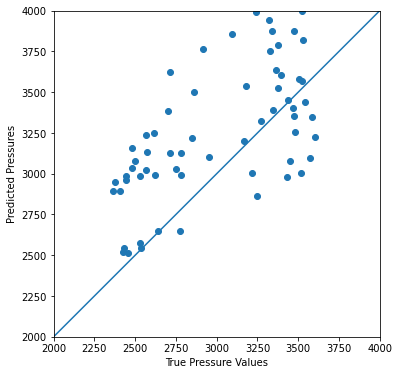

time: 236 ms (started: 2021-12-21 10:50:49 +00:00)


In [ ]:
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test_filtered, y_predicted)
plt.xlabel('True Load Values')
plt.ylabel('Predicted Loads')
lims = [2000, 4000]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

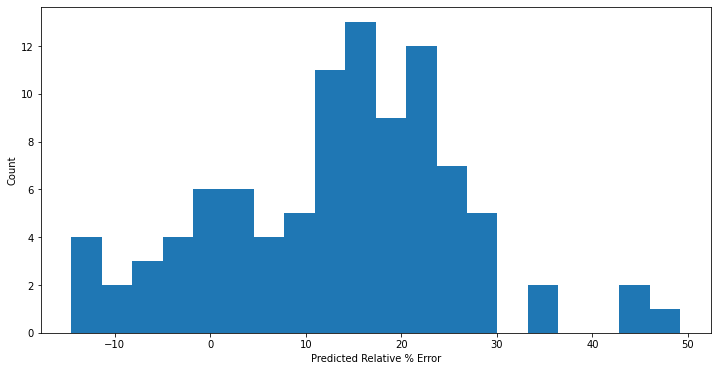

time: 277 ms (started: 2021-12-21 10:50:49 +00:00)


In [ ]:
# Calculating the error variations:
error_nn = (y_predicted - y_test_filtered)/y_test_filtered*100
plt.hist(error_nn, bins=20)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [ ]:
#Calculating the mean absolutepercentage error:
abs_error_nn = abs(y_predicted - y_test_filtered)/y_test_filtered*100
np.average(error_nn)

13.456460237695916

time: 9.68 ms (started: 2021-12-21 10:50:49 +00:00)


In [ ]:
#Calculating R2 value:
r2_test = r2_score(y_test_filtered, y_predicted)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  -0.71
time: 5.42 ms (started: 2021-12-21 10:50:49 +00:00)


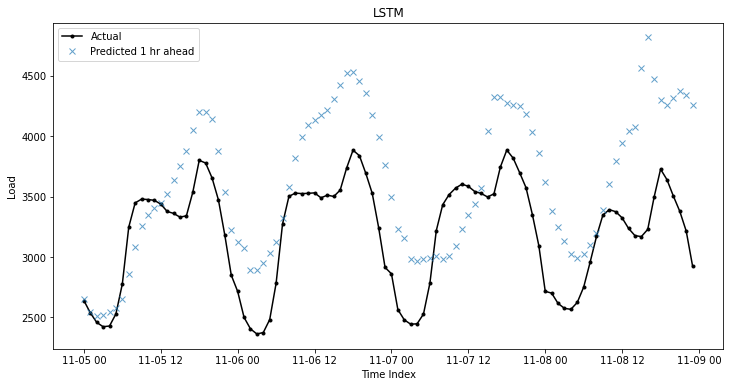

time: 283 ms (started: 2021-12-21 10:50:49 +00:00)


In [ ]:
#Plotting the Figure: 
plt.figure();
plt.plot(y_test_filtered, 'k.-');
plt.plot(y_predicted, 'x', alpha=0.70);

plt.legend(['Actual',
            'Predicted 1 hr ahead'
            ]);
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('LSTM');
mpl.rcParams['figure.figsize'] = [12.0, 6.0]

You should note that what we have seen so far is the vanilla LSTM. There are also more complex networks such as Encoder-Decoder LSTM, CNN-LSTM, ConvLSTM Encoder-Decoder etc. One you experience that basic approaches is not sufficient and/or efficient for your problem, you may explore more complex solutions. We will explore some at the end of the lecture.

# Gated Recurrent Unit (GRU) Cells

GRU is a more recent interpretation of the recurrent neural network, which also uses gating mechanism. The architecture of GRU is very similar to that of LSTM but with fewer parameters (GRU excludes the output gate). It is typically better for smaller datasets. To be more precise, rather than a separate cell state, the GRU uses
the hidden state as memory. It also merges the
forget input gates into a single “update” gate.

See the below link for further details:

https://keras.io/api/layers/recurrent_layers/gru/


```
tf.keras.layers.GRU(
    units,
    activation="tanh",
    recurrent_activation="sigmoid",
    use_bias=True,
    kernel_initializer="glorot_uniform",
    recurrent_initializer="orthogonal",
    bias_initializer="zeros",
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    unroll=False,
    time_major=False,
    reset_after=True,
    **kwargs
)

```



In [ ]:
#Reshaping the 2D data into 3D:[samples, timesteps, features]
#Note that reshape is no longer available in Pandas; this is why we convert it to numpy
#array first.
X_train, y_train, iy_train  = dimension_fix(X_train0, y_train0,24,1)
X_val, y_val, iy_val = dimension_fix(X_val0, y_val0,24,1)
X_test, y_test, iy_test = dimension_fix(X_test0, y_test0,24,1)
print(X_train.shape, y_train.shape,X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(18880, 24, 4) (18880, 1) (96, 24, 4) (96, 1) (96, 24, 4) (96, 1)
time: 77.3 ms (started: 2021-12-21 10:50:50 +00:00)


In [ ]:
X_test[0]

array([[-0.35606169,  1.79197761,  0.22623962, -1.13057255],
       [-0.89235431,  1.16481917, -0.71324627, -1.29745466],
       [-1.2346298 ,  0.27439463, -0.80040968, -1.41947599],
       [-1.38197299, -0.62535648, -0.88705116, -1.45357018],
       [-1.44969595, -0.96324176, -0.85260334, -1.43024257],
       [-1.44969595, -0.81010618, -0.80040968, -1.22747184],
       [-1.35177221,  0.27342461, -0.69602236, -0.7034979 ],
       [-0.98112629,  1.74659534, -0.59163504,  0.09502402],
       [-0.30664223,  1.99613009, -0.57388919,  0.38213303],
       [ 0.24703871,  1.05756652, -0.3828604 ,  0.43417154],
       [ 0.40444883, -0.57567265, -0.20853357,  0.40366621],
       [ 0.43098891, -1.14906684, -0.01750477,  0.44314369],
       [ 0.43098891, -1.14906684,  0.19126987,  0.38213303],
       [ 0.40444883, -1.0013327 ,  0.31340304,  0.29779476],
       [ 0.3504535 , -0.9593418 ,  0.3655967 ,  0.29779476],
       [ 0.30744027, -1.00566578,  0.43501427,  0.23498966],
       [ 0.30560992, -1.

time: 7.58 ms (started: 2021-12-21 10:50:50 +00:00)


In [ ]:
#Defining the window width:
width = 4
rnn_window = X_train.shape[1]
#Last loads: will be used for median and std calculation:
last_loads = np.array([ X_test[0][i][3] for i in range(rnn_window-width, rnn_window)])
last_loads

array([ 0.69795294,  0.4090495 , -0.13466318, -0.70708676])

time: 7.88 ms (started: 2021-12-21 10:50:50 +00:00)


In [ ]:
#Creating series for predictions:
y_predicted =pd.Series(index=y_test_filtered.index)

time: 3.03 ms (started: 2021-12-21 10:50:50 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [ ]:
#Model is already trained so let's use it directly:
# Modifying the shape of initial test point for RNN
# [samples, timesteps, features] is needed. Currently, we only have [timesteps, features].
X_test_last = X_test[0].reshape((1,X_test[0].shape[0], X_test[0].shape[1]))
X_test_last

array([[[-0.35606169,  1.79197761,  0.22623962, -1.13057255],
        [-0.89235431,  1.16481917, -0.71324627, -1.29745466],
        [-1.2346298 ,  0.27439463, -0.80040968, -1.41947599],
        [-1.38197299, -0.62535648, -0.88705116, -1.45357018],
        [-1.44969595, -0.96324176, -0.85260334, -1.43024257],
        [-1.44969595, -0.81010618, -0.80040968, -1.22747184],
        [-1.35177221,  0.27342461, -0.69602236, -0.7034979 ],
        [-0.98112629,  1.74659534, -0.59163504,  0.09502402],
        [-0.30664223,  1.99613009, -0.57388919,  0.38213303],
        [ 0.24703871,  1.05756652, -0.3828604 ,  0.43417154],
        [ 0.40444883, -0.57567265, -0.20853357,  0.40366621],
        [ 0.43098891, -1.14906684, -0.01750477,  0.44314369],
        [ 0.43098891, -1.14906684,  0.19126987,  0.38213303],
        [ 0.40444883, -1.0013327 ,  0.31340304,  0.29779476],
        [ 0.3504535 , -0.9593418 ,  0.3655967 ,  0.29779476],
        [ 0.30744027, -1.00566578,  0.43501427,  0.23498966],
        

time: 15.6 ms (started: 2021-12-21 10:50:50 +00:00)


In [ ]:
#Data was already prepared:
print(X_train.shape, y_train.shape,X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(18880, 24, 4) (18880, 1) (96, 24, 4) (96, 1) (96, 24, 4) (96, 1)
time: 2.72 ms (started: 2021-12-21 10:50:50 +00:00)


In [ ]:
def build_model_GRU():
  #Here we will use Sequential API
  n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
  model = models.Sequential([
  layers.GRU(32, return_sequences=True,input_shape=(None, n_features), stateful=False), 
  layers.BatchNormalization(),
  layers.GRU(32, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.GRU(32, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.GRU(32, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.GRU(32, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.GRU(32, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.GRU(32, stateful=False),
  layers.BatchNormalization(),
  layers.Dense(n_outputs)                     
  ])
  model.compile(optimizer='Adam',loss='mse',metrics='mae') 
  return model


time: 26.4 ms (started: 2021-12-21 10:50:50 +00:00)


In [ ]:
#Looking at the graph:
build_model_GRU().summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 32)          3648      
                                                                 
 batch_normalization_38 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 gru_1 (GRU)                 (None, None, 32)          6336      
                                                                 
 batch_normalization_39 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 gru_2 (GRU)                 (None, None, 32)          6336      
                                                                 
 batch_normalization_40 (Bat  (None, None, 32)        

In [ ]:
#We will first create the object to feed fit() method:
myCheckpointGRU= keras.callbacks.ModelCheckpoint("my_best_model_GRU.h5", save_best_only=True)

time: 1.57 ms (started: 2021-12-21 10:50:52 +00:00)


In [ ]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
myEarly_stoppingGRU= keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

time: 1.83 ms (started: 2021-12-21 10:50:52 +00:00)


In [ ]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 150
batch_size = 32

time: 1.78 ms (started: 2021-12-21 10:50:52 +00:00)


### Model Training

In [ ]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
model_GRU = build_model_GRU()

#Training step: Trains the model in silent mode (verbose = 0)
history_GRU = model_GRU.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val, y_val) , 
                                 callbacks=[myCheckpointGRU,myEarly_stoppingGRU])#, verbose=0)
#Calling back the best model:
model_best_GRU = keras.models.load_model("my_best_model_GRU.h5")


Epoch 1/150
590/590 [==============================] - 52s 72ms/step - loss: 11159544.0000 - mae: 3297.2964 - val_loss: 9890129.0000 - val_mae: 3120.1663
Epoch 2/150
590/590 [==============================] - 40s 67ms/step - loss: 10744474.0000 - mae: 3245.1716 - val_loss: 9574759.0000 - val_mae: 3078.8625
Epoch 3/150
590/590 [==============================] - 40s 67ms/step - loss: 10033451.0000 - mae: 3147.6309 - val_loss: 8981028.0000 - val_mae: 2989.5574
Epoch 4/150
590/590 [==============================] - 40s 67ms/step - loss: 9140629.0000 - mae: 3014.0786 - val_loss: 8638703.0000 - val_mae: 2937.3604
Epoch 5/150
590/590 [==============================] - 40s 67ms/step - loss: 8153925.5000 - mae: 2851.5320 - val_loss: 7649391.5000 - val_mae: 2765.4229
Epoch 6/150
590/590 [==============================] - 40s 68ms/step - loss: 7117082.0000 - mae: 2664.4224 - val_loss: 6798738.5000 - val_mae: 2606.7673
Epoch 7/150
590/590 [==============================] - 40s 67ms/step - loss: 60

In [ ]:
#Let's look into the history recorded:
histGRU = pd.DataFrame(history_GRU.history)
histGRU.sample(3)

,loss,mae,val_loss,val_mae
14,239711.234375,472.729034,157840.390625,393.109283
17,17948.884766,107.135941,4777.328125,60.202747
33,11105.433594,84.213860,3088.049805,46.184635


time: 24.7 ms (started: 2021-12-21 11:18:28 +00:00)


In [ ]:
#Adding epoch column:
histGRU['epoch'] = history_GRU.epoch
# As you can see, we have the losses as well as mae for both training and CV data:
histGRU.sample(3)

,loss,mae,val_loss,val_mae,epoch
28,11603.770508,85.684441,1452.897095,27.670431,28
17,17948.884766,107.135941,4777.328125,60.202747,17
23,11842.647461,87.629051,4509.065918,57.466366,23


time: 17.3 ms (started: 2021-12-21 11:18:28 +00:00)


In [ ]:
# Defining our function to see the evolution of error:
def plot_learning_curves(history):
  #We will omit the first 10 points for a better visualization:
  plt.plot(history['epoch'],history['loss'], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'],history['val_loss'], "b-.", linewidth=1.5, label="Validation")
  plt.legend()
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("Loss (MSE)")

time: 6.71 ms (started: 2021-12-21 11:18:28 +00:00)


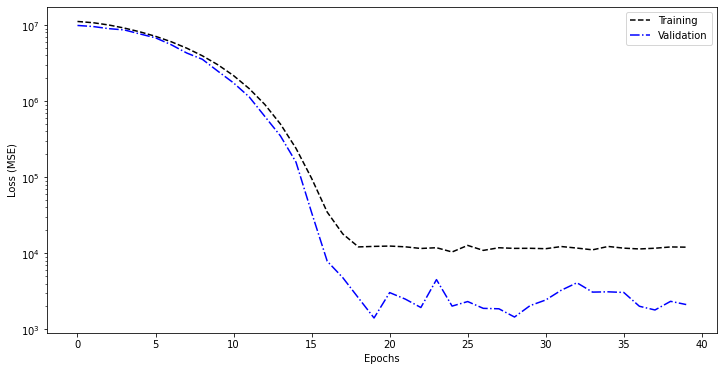

time: 598 ms (started: 2021-12-21 11:18:28 +00:00)


In [ ]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(histGRU)

In [ ]:
#Label and indices:
#Since we have shifted the data by 4 width windows, initial label DF is to be filtered.
y_test_filtered = y_test0.loc[iy_test]
y_test_filtered

2014-11-05 00:00:00    2640.0
2014-11-05 01:00:00    2538.0
2014-11-05 02:00:00    2459.0
2014-11-05 03:00:00    2423.0
2014-11-05 04:00:00    2429.0
                        ...  
2014-11-08 19:00:00    3640.0
2014-11-08 20:00:00    3504.0
2014-11-08 21:00:00    3378.0
2014-11-08 22:00:00    3215.0
2014-11-08 23:00:00    2924.0
Length: 96, dtype: float64

time: 11.8 ms (started: 2021-12-21 11:18:28 +00:00)


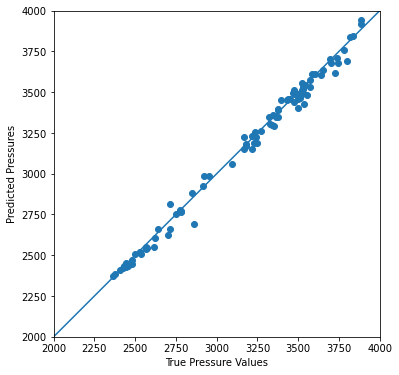

time: 2.75 s (started: 2021-12-21 11:18:28 +00:00)


In [ ]:
# Calling trained model for predictions:
Y_test_predictions = pd.Series(model_best_GRU.predict(X_test).flatten(),index=y_test_filtered.index)

#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test, Y_test_predictions)
plt.xlabel('True Load Values')
plt.ylabel('Predicted Loads')
lims = [2000, 4000]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

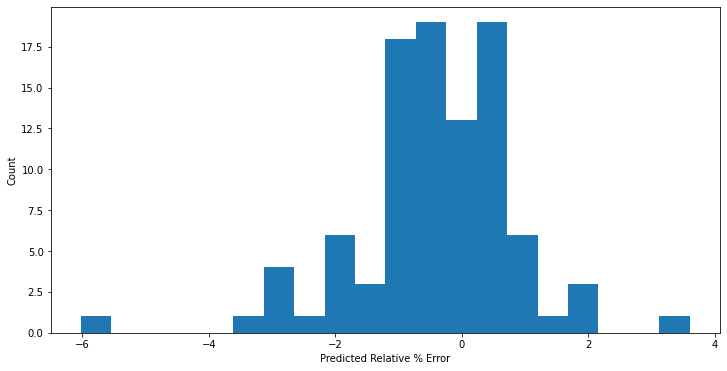

time: 274 ms (started: 2021-12-21 11:18:31 +00:00)


In [ ]:
# Calculating the error variations:
error_nn = (Y_test_predictions - y_test_filtered)/y_test_filtered*100
plt.hist(error_nn, bins=20)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [ ]:
#Calculating the mean absolutepercentage error:
abs_error_nn = abs(Y_test_predictions - y_test_filtered)/y_test_filtered*100
np.average(error_nn)

-0.3932622805794031

time: 8.07 ms (started: 2021-12-21 11:18:31 +00:00)


In [ ]:
#Calculating R2 value:
r2_test = r2_score(y_test_filtered, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.99
time: 2.28 ms (started: 2021-12-21 11:18:31 +00:00)


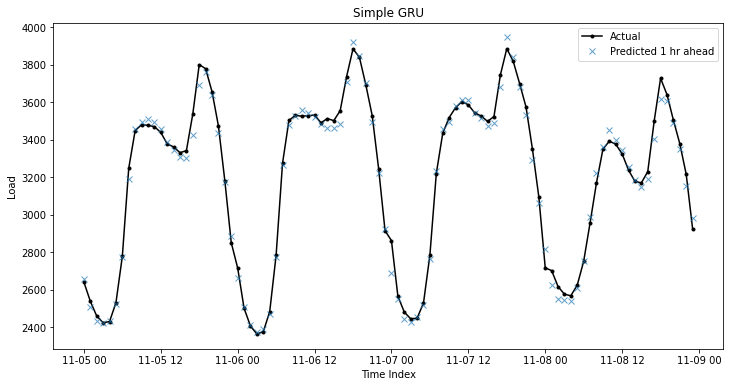

time: 284 ms (started: 2021-12-21 11:18:31 +00:00)


In [ ]:
#Plotting the Figure: 
plt.figure();
plt.plot(y_test_filtered, 'k.-');
plt.plot(Y_test_predictions, 'x', alpha=0.70);

plt.legend(['Actual',
            'Predicted 1 hr ahead'
            ]);
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('Simple GRU');
mpl.rcParams['figure.figsize'] = [12.0, 6.0]

## GRU: multi-step forecasting

In [ ]:
#Reshaping the 2D data into 3D:[samples, timesteps, features]
#Note that reshape is no longer available in Pandas; this is why we convert it to numpy
#array first.
X_train, y_train, iy_train  = dimension_fix(X_train0, y_train0,24,1)
X_val, y_val, iy_val = dimension_fix(X_val0, y_val0,24,1)
X_test, y_test, iy_test = dimension_fix(X_test0, y_test0,24,1)
print(X_train.shape, y_train.shape,X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(18880, 24, 4) (18880, 1) (96, 24, 4) (96, 1) (96, 24, 4) (96, 1)
time: 81.8 ms (started: 2021-12-21 11:18:32 +00:00)


In [ ]:
#Defining the window width:
width = 4
rnn_window = X_train.shape[1]
#Last loads: will be used for median and std calculation:
last_loads = np.array([ X_test[0][i][3] for i in range(rnn_window-width, rnn_window)])
last_loads

array([ 0.69795294,  0.4090495 , -0.13466318, -0.70708676])

time: 9.01 ms (started: 2021-12-21 11:18:32 +00:00)


In [ ]:
#Creating series for predictions:
y_predicted =pd.Series(index=y_test_filtered.index)

time: 2.34 ms (started: 2021-12-21 11:18:32 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [ ]:
#Model is already trained so let's use it directly:
# Modifying the shape of initial test point for RNN
# [samples, timesteps, features] is needed. Currently, we only have [timesteps, features].
X_test_last = X_test[0].reshape((1,X_test[0].shape[0], X_test[0].shape[1]))
X_test_last

array([[[-0.35606169,  1.79197761,  0.22623962, -1.13057255],
        [-0.89235431,  1.16481917, -0.71324627, -1.29745466],
        [-1.2346298 ,  0.27439463, -0.80040968, -1.41947599],
        [-1.38197299, -0.62535648, -0.88705116, -1.45357018],
        [-1.44969595, -0.96324176, -0.85260334, -1.43024257],
        [-1.44969595, -0.81010618, -0.80040968, -1.22747184],
        [-1.35177221,  0.27342461, -0.69602236, -0.7034979 ],
        [-0.98112629,  1.74659534, -0.59163504,  0.09502402],
        [-0.30664223,  1.99613009, -0.57388919,  0.38213303],
        [ 0.24703871,  1.05756652, -0.3828604 ,  0.43417154],
        [ 0.40444883, -0.57567265, -0.20853357,  0.40366621],
        [ 0.43098891, -1.14906684, -0.01750477,  0.44314369],
        [ 0.43098891, -1.14906684,  0.19126987,  0.38213303],
        [ 0.40444883, -1.0013327 ,  0.31340304,  0.29779476],
        [ 0.3504535 , -0.9593418 ,  0.3655967 ,  0.29779476],
        [ 0.30744027, -1.00566578,  0.43501427,  0.23498966],
        

time: 19.1 ms (started: 2021-12-21 11:18:32 +00:00)


In [ ]:
#Going into loop: we will loop over the y_test indices and update X_test_last at each loop:
case_indices = y_test_filtered.index
#For scaling the predictions:
dummy_array = np.zeros((1,4))
for case_index in case_indices:
  #Predicting with fitted GRU and writing the result on y_predicted at the same time:
  load_prediction = model_best_GRU.predict(X_test_last).flatten()[0]
  y_predicted.update(pd.Series(load_prediction,index=[case_index]))
  #Preparing the next X_test_last:
  #
  # We need to scale the load first:
  dummy_array[0,3] = load_prediction
  load_scaled = sX.transform(dummy_array)[0,3]
  #
  #---updating load list---:
  last_loads = np.delete(last_loads,0)
  last_loads = np.append(last_loads,load_scaled)
# print(last_loads)
  #
  #---finding new values:
  median_i = np.median(last_loads)
  std_i = np.std(last_loads)
  #here I assume that T data is available from weatherforecasting etc.
  time_index = pd.Timestamp(case_index) + DateOffset(hours=1)
  temp_i= temp_test.loc[time_index] #already scaled!
  #
  #shifting lines:
  for i in range (X_test_last.shape[1]-1):
    X_test_last[0][i]= X_test_last[0][i+1]
  X_test_last[0][X_test_last.shape[1]-1]=np.array([median_i,std_i,temp_i,load_scaled])


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid 

time: 9.29 s (started: 2021-12-21 11:18:32 +00:00)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


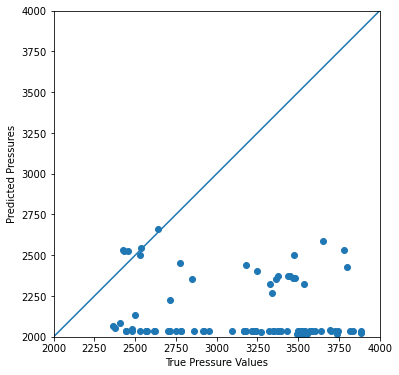

time: 231 ms (started: 2021-12-21 11:18:41 +00:00)


In [ ]:
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test_filtered, y_predicted)
plt.xlabel('True Load Values')
plt.ylabel('Predicted Loads')
lims = [2000, 4000]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

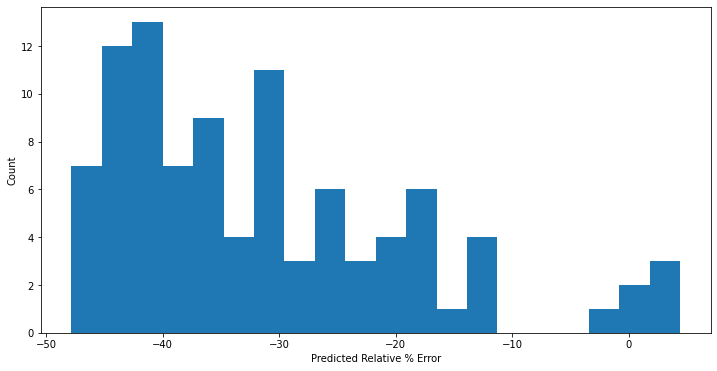

time: 267 ms (started: 2021-12-21 11:18:41 +00:00)


In [ ]:
# Calculating the error variations:
error_nn = (y_predicted - y_test_filtered)/y_test_filtered*100
plt.hist(error_nn, bins=20)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [ ]:
#Calculating the mean absolutepercentage error:
abs_error_nn = abs(y_predicted - y_test_filtered)/y_test_filtered*100
np.average(error_nn)

-31.440758816292718

time: 10.1 ms (started: 2021-12-21 11:18:42 +00:00)


In [ ]:
#Calculating R2 value:
r2_test = r2_score(y_test_filtered, y_predicted)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  -5.83
time: 3.48 ms (started: 2021-12-21 11:18:42 +00:00)


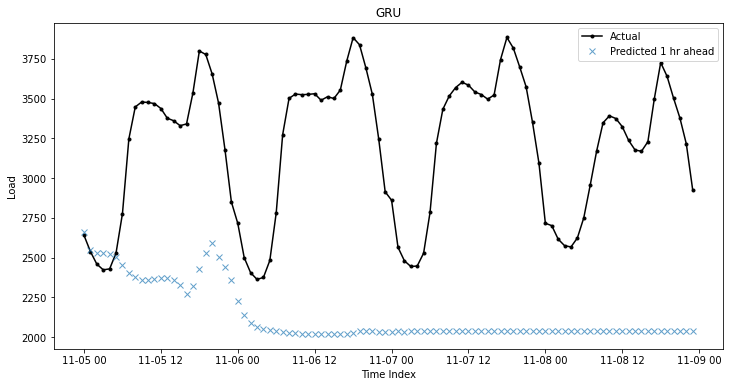

time: 268 ms (started: 2021-12-21 11:18:42 +00:00)


In [ ]:
#Plotting the Figure: 
plt.figure();
plt.plot(y_test_filtered, 'k.-');
plt.plot(y_predicted, 'x', alpha=0.70);

plt.legend(['Actual',
            'Predicted 1 hr ahead'
            ]);
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('GRU');
mpl.rcParams['figure.figsize'] = [12.0, 6.0]

# The Autoencoder: "Machine Translation"

RNN was originally born for language modeling and machine translation, but as we have seen so far it also works well with other sequential data such as load forecasting. 

Historically speaking, up to this point, we have covered up to around 2015. A more recent trend is the architecture called autoencoder for "seq2seq" model. A popular use case is the NLP and machine translation. 

The autoencoder is composed of two recurrent layers. In the first layer, input data is fully processed. Here we assume that the hidden state of the first layer reflects "the learn the content"; i.e., spatial dependencies. This refined knowledge than passed to a new model, which decode the meaning into a new coordinate system (eg. another language). It has been experienced in the community that autoencoders are also good at predicting univariate and multivariate time series data. This is why it is a good tool for you to have! Let's see how it is iplemented in this section. 

We will go into the details of autoencoders next week as well.  

In [ ]:
#Data was already prepared:
print(X_train.shape, y_train.shape,X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(18880, 24, 4) (18880, 1) (96, 24, 4) (96, 1) (96, 24, 4) (96, 1)
time: 1.62 ms (started: 2021-12-21 11:18:42 +00:00)


In [ ]:
#Reshaping the 2D data into 3D:[samples, timesteps, features]
#Note that reshape is no longer available in Pandas; this is why we convert it to numpy
#array first.
X_train, y_train, iy_train  = dimension_fix(X_train0, y_train0,24,24)
X_val, y_val, iy_val = dimension_fix(X_val0, y_val0,24,24)
X_test, y_test, iy_test = dimension_fix(X_test0, y_test0,24,24)
print(X_train.shape, y_train.shape,X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(18848, 24, 4) (18848, 24) (96, 24, 4) (96, 24) (96, 24, 4) (96, 24)
time: 71.6 ms (started: 2021-12-21 11:18:42 +00:00)


In [ ]:
#Check the shifts by 24 hours:
iy_test[0],y_test[0]

(Timestamp('2014-11-05 00:00:00'),
 array([2640., 2538., 2459., 2423., 2429., 2529., 2777., 3247., 3448.,
        3479., 3476., 3469., 3438., 3377., 3361., 3330., 3341., 3537.,
        3800., 3778., 3655., 3472., 3179., 2850.]))

time: 8.04 ms (started: 2021-12-21 11:18:42 +00:00)


In [ ]:
#Original dataset:
y_test0.index[24], y_test0[24],y_test0[25]

(Timestamp('2014-11-05 00:00:00'), 2640.0, 2538.0)

time: 7.32 ms (started: 2021-12-21 11:18:42 +00:00)


**Important note:**

The encoder will produce a 2-dimensional matrix of outputs, where the length is defined by the number of memory cells in the layer. The decoder is an RNN layer so it expects a 3D input of [samples, time steps, features] in order to produce a decoded sequence of some different length defined by the problem. How are we going to link these two layers? 

The ansswer is the `RepeatVector` layer. It repeats the provided 2D input multiple times to create a 3D output.

https://keras.io/api/layers/reshaping_layers/repeat_vector/

We can tune the RepeatVector to repeat the fixed length vector one time for each time step in the expected output sequence. Here, if you have multiple outputs, you need to modify the last layer as well. One solution is the `TimeDistributed` wrapper which allows the same output layer to be reused for each element in the output sequence:

`model.add(TimeDistributed(Dense(...)))`

In [ ]:
def build_model_ED():
  #Here we will use Sequential API
  n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
  model = models.Sequential([
  # define the encoder:
  layers.LSTM(32, return_sequences=True,input_shape=(None, n_features), stateful=False),
  layers.BatchNormalization(),
  layers.LSTM(32, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.LSTM(32, return_sequences=False, stateful=False),
  layers.BatchNormalization(),
  layers.RepeatVector(n_timesteps),
  # define decoder:
  layers.LSTM(32, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.LSTM(32, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.LSTM(32, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.Dense(32, kernel_regularizer=regularizers.l2(0.0001), kernel_initializer="he_normal"),layers.LeakyReLU(alpha=0.1),
  layers.BatchNormalization(),
  layers.TimeDistributed(layers.Dense(1))                     
  ])
  model.compile(optimizer='Adam',loss='mse',metrics='mae') 
  return model


time: 25 ms (started: 2021-12-21 11:18:42 +00:00)


In [ ]:
build_model_ED().summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, None, 32)          4736      
                                                                 
 batch_normalization_52 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 lstm_15 (LSTM)              (None, None, 32)          8320      
                                                                 
 batch_normalization_53 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 lstm_16 (LSTM)              (None, 32)                8320      
                                                                 
 batch_normalization_54 (Bat  (None, 32)              

In [ ]:
#We will first create the object to feed fit() method:
myCheckpointED= keras.callbacks.ModelCheckpoint("my_best_model_ED.h5", save_best_only=True)

time: 949 µs (started: 2021-12-21 11:18:44 +00:00)


In [ ]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
myEarly_stoppingED = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

time: 1.78 ms (started: 2021-12-21 11:18:44 +00:00)


In [ ]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 150
batch_size = 32

time: 1.36 ms (started: 2021-12-21 11:18:44 +00:00)


### Model Training

In [ ]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
model_ED = build_model_ED()

#Training step: Trains the model in silent mode (verbose = 0)
history_ED = model_ED.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val, y_val) , 
                                 callbacks=[myCheckpointED,myEarly_stoppingED])#, verbose=0)
#Calling back the best model:
model_best_ED = keras.models.load_model("my_best_model_ED.h5")


Epoch 1/150
589/589 [==============================] - 45s 61ms/step - loss: 11160631.0000 - mae: 3297.1765 - val_loss: 9888697.0000 - val_mae: 3120.9573
Epoch 2/150
589/589 [==============================] - 34s 58ms/step - loss: 10729975.0000 - mae: 3243.3447 - val_loss: 9678605.0000 - val_mae: 3095.2012
Epoch 3/150
589/589 [==============================] - 34s 57ms/step - loss: 10013115.0000 - mae: 3144.7971 - val_loss: 9191729.0000 - val_mae: 3023.0642
Epoch 4/150
589/589 [==============================] - 34s 58ms/step - loss: 9122229.0000 - mae: 3010.6550 - val_loss: 8503342.0000 - val_mae: 2911.9041
Epoch 5/150
589/589 [==============================] - 34s 58ms/step - loss: 8140470.5000 - mae: 2847.9128 - val_loss: 7933189.5000 - val_mae: 2812.9036
Epoch 6/150
589/589 [==============================] - 34s 57ms/step - loss: 7105285.5000 - mae: 2660.5110 - val_loss: 6546546.5000 - val_mae: 2554.1467
Epoch 7/150
589/589 [==============================] - 34s 58ms/step - loss: 60

In [ ]:
#Let's look into the history recorded:
histED = pd.DataFrame(history_ED.history)
histED.sample(3)

,loss,mae,val_loss,val_mae
1,1.072998e+07,3243.344727,9.678605e+06,3095.201172
30,1.217555e+04,83.130699,1.802014e+04,96.901855
37,1.103313e+04,79.434685,1.943319e+04,95.822929


time: 22.5 ms (started: 2021-12-21 11:43:19 +00:00)


In [ ]:
#Adding epoch column:
histED['epoch'] = history_ED.epoch
# As you can see, we have the losses as well as mae for both training and CV data:
histED.sample(3)

,loss,mae,val_loss,val_mae,epoch
18,1.479147e+04,91.393181,2.035603e+04,103.592079,18
3,9.122229e+06,3010.655029,8.503342e+06,2911.904053,3
32,1.188329e+04,82.406471,1.941283e+04,96.642509,32


time: 22.3 ms (started: 2021-12-21 11:43:19 +00:00)


In [ ]:
# Defining our function to see the evolution of error:
def plot_learning_curves(history):
  #We will omit the first 10 points for a better visualization:
  plt.plot(history['epoch'],history['loss'], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'],history['val_loss'], "b-.", linewidth=1.5, label="Validation")
  plt.legend()
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("Loss (MSE)")

time: 4.81 ms (started: 2021-12-21 11:43:19 +00:00)


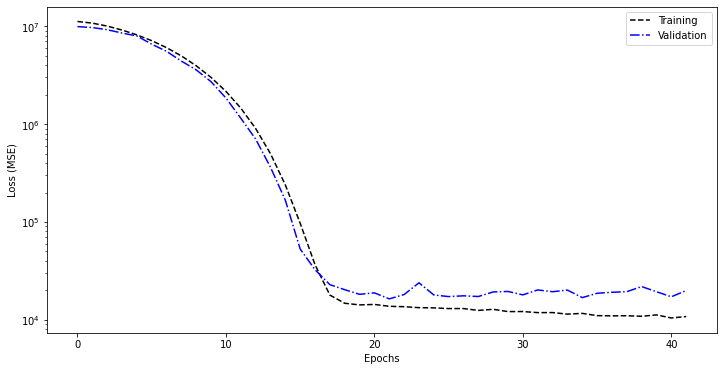

time: 551 ms (started: 2021-12-21 11:43:19 +00:00)


In [ ]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(histED)

In [ ]:
#Let's pick one data point:
case_test = X_test[0].reshape((1,X_test[0].shape[0], X_test[0].shape[1]))

time: 1.17 ms (started: 2021-12-21 11:43:20 +00:00)


In [ ]:
Y_test_predictions = pd.Series(model_best_ED.predict(case_test).flatten(),index=iy_test[:case_test.shape[1]])
y_test_filtered = y_test0.loc[Y_test_predictions.index]

time: 3.37 s (started: 2021-12-21 11:43:20 +00:00)


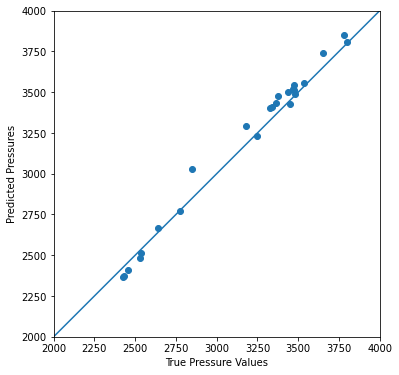

time: 274 ms (started: 2021-12-21 11:43:23 +00:00)


In [ ]:
# Calling trained model for predictions:

#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test_filtered, Y_test_predictions)
plt.xlabel('True Load Values')
plt.ylabel('Predicted Loads')
lims = [2000, 4000]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

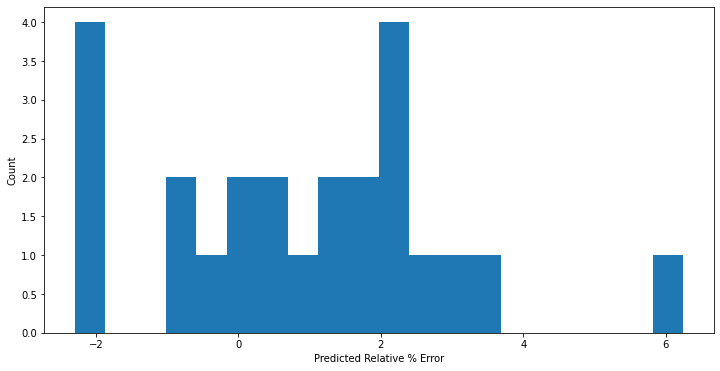

time: 293 ms (started: 2021-12-21 11:43:24 +00:00)


In [ ]:
# Calculating the error variations:
error_nn = (Y_test_predictions - y_test_filtered)/y_test_filtered*100
plt.hist(error_nn, bins=20)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [ ]:
#Calculating the mean absolutepercentage error:
abs_error_nn = abs(Y_test_predictions - y_test_filtered)/y_test_filtered*100
np.average(error_nn)

0.8827561240396324

time: 9.25 ms (started: 2021-12-21 11:43:24 +00:00)


In [ ]:
#Calculating R2 value:
r2_test = r2_score(y_test_filtered, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.98
time: 4.3 ms (started: 2021-12-21 11:43:24 +00:00)


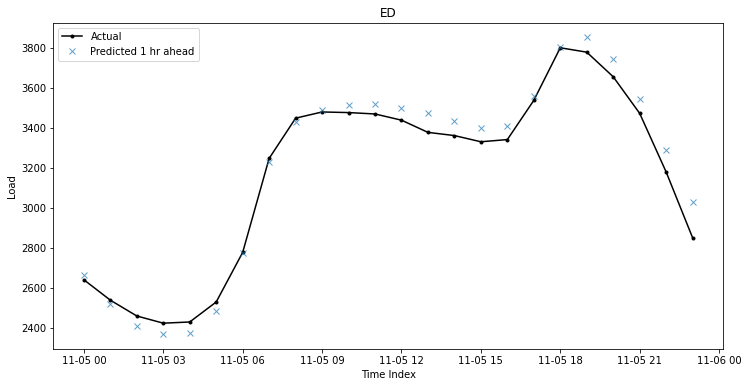

time: 294 ms (started: 2021-12-21 11:43:24 +00:00)


In [ ]:
#Plotting the Figure: 
plt.figure();
plt.plot(y_test_filtered, 'k.-');
plt.plot(Y_test_predictions, 'x', alpha=0.70);

plt.legend(['Actual',
            'Predicted 1 hr ahead'
            ]);
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('ED');
mpl.rcParams['figure.figsize'] = [12.0, 6.0]

# Further Reading Materials

https://www.pyimagesearch.com/2019/10/14/why-is-my-validation-loss-lower-than-my-training-loss/

Backprop through time: 

https://en.wikipedia.org/wiki/Backpropagation_through_time

http://ir.hit.edu.cn/~jguo/docs/notes/bptt.pdf

LSTM: Original paper

[Sepp Hochreiter and Jürgen Schmidhuber, “Long Short-Term Memory](https://www.bioinf.jku.at/publications/older/2604.pdf),” Neural Computation 9, no. 8 (1997): 1735–1780
